In [1]:
# micro precision https://www.cnblogs.com/xxBryce/p/13093636.html

# 简介：
单序列模型的前向推理和热图绘制

# 导入

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from matplotlib import font_manager
# for font in sorted( font_manager.fontManager.ttflist, key=lambda font: font.name ):
#     # 查看字体名以及对应的字体文件名
#     print(font.name, '-', font.fname) 
plt.rcParams['font.sans-serif'] = 'Times New Roman'

from PIL import Image

import SimpleITK as sitk

import os
# os.environ ["CUDA_VISIBLE_DEVICES"] = '6,7' 
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from models.model_toad import *
from datasets.WRZ_DataSet_withMask import *

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import classification_report

from copy import deepcopy

import sys
sys.path.append('./utils')
from test_utils import *
from metric_utils import *
# from metric_utils import bootstrap_score

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 参数

## 纯影像模型

In [3]:
# params = {
#     'device': 'cuda',
#     'gpu': '0',
#     'trained_model_filepath': 'results/SWS_withMask_3category_ZSSYandMMSY_20221124_s1/s_{}_checkpoint.pt',
#     'pkl_filepath': './results/SWS_withMask_3category_ZSSYandMMSY_20221124_s1/split_{}_results.pkl',# K折交叉验证的验证集结果
#     'pats': ['/local_data_ssd/huaqing/tyler/MedAI/WRZ/data/AI_Final_Data/SDFY_processed/*/*SWS.nii.gz',],

#     'heatmap_dir': 'results/SWS_withMask_3category_ZSSYandMMSY_20221124_s1/heatmap',# 保存热图到该路径
#     'clses_name': {"aCSVD":0, "CADASIL":1, "CAA":2},#{"0":0,"1":1},#{"aCSVD":0, "CADASIL":1, "CAA":2},
#     'clinical_filepath': {"SDFY":"../../data/AI_Final_Data/SDFY/SDFY_Clinical.xlsx"},
#     'mix': False,
#     'filepath_Human_prediction': '../../data/AI_Final_Data/SDFY/SDFY_Data_Professors_judge_result_Final.xlsx',# 外部测试集上医生的预测
#     'Dr_names': ['秦冰','魏磊','卢婷婷','黄雪泓','刘旭'],
#     'filepath_save_Dr_Metrics': 'results/SWS_withMask_3category_ZSSYandMMSY_20221124_s1/医生的指标.xlsx',
#     'filepath_save_Dr_CM': 'results/SWS_withMask_3category_ZSSYandMMSY_20221124_s1/医生混淆矩阵.tiff',
   
#     'filepath_save_KFold_IntTestSetCat_ROC': 'results/SWS_withMask_3category_ZSSYandMMSY_20221124_s1/K折交叉验证模型在DevelopmentSet上测试集（串联）的ROC曲线.tiff',
#     'filepath_save_KFold_IntTestSetCat_CM': 'results/SWS_withMask_3category_ZSSYandMMSY_20221124_s1/K折交叉验证模型在DevelopmentSet上测试集（串联）的混淆矩阵.tiff',
#     'filepath_save_KFold_IntTestSet_Metrics': 'results/SWS_withMask_3category_ZSSYandMMSY_20221124_s1/K折交叉验证单个模型在DevelopmentSet上测试集（单折）的指标.xlsx',
#     'filepath_save_KFold_ExtTestSet_ROC': 'results/SWS_withMask_3category_ZSSYandMMSY_20221124_s1/K折交叉验证单个模型在外部测试集（串联）的ROC曲线.tiff',
#     'filepath_save_KFold_ExtTestSet_CM': 'results/SWS_withMask_3category_ZSSYandMMSY_20221124_s1/K折交叉验证单个模型在外部测试集（串联）的混淆矩阵.tiff',
#     'filepath_save_EnsAI_ExtTestSet_ROC': 'results/SWS_withMask_3category_ZSSYandMMSY_20221124_s1/集成模型在SDFY上的ROC曲线.tiff',
#     'filepath_save_EnsAI_ExtTestSet_CM': 'results/SWS_withMask_3category_ZSSYandMMSY_20221124_s1/集成模型在外部测试集的混淆矩阵.tiff',
#     'filepath_save_KFold_and_Ens_ExtTestSet_Metrics': 'results/SWS_withMask_3category_ZSSYandMMSY_20221124_s1/K折交叉验证单个模型和集成模型在外部测试集的指标.xlsx',
#     'filepath_save_KappaConsistencyTest_ExtTestSet': 'results/SWS_withMask_3category_ZSSYandMMSY_20221124_s1/集成模型和医生在外部测试集的一致性检验.xlsx',

#     'dpi': 1200,
#     'gray_dpi': 450,
#     'color_list': np.array([
#         [255,194,10],
#         [12,123,220],
#         [153,79,0],
#         [75,0,146],
#         [230,97,0],
#         [93,58,155],
#         [26,255,26],
#         [254,254,98],
#         [211,95,183],
#         [26,133,255],
#         [212,17,89],
#     ])/255.0,
#     'seed': 42,
# }

## 混合模型

In [4]:
params = {
    'device': 'cuda',
    'gpu': '0',
    'trained_model_filepath': 'results/SWS_withMask_mix_3category_ZSSYandMMSY_20221124_s1/s_{}_checkpoint.pt',
    'pkl_filepath': './results/SWS_withMask_mix_3category_ZSSYandMMSY_20221124_s1/split_{}_results.pkl',# K折交叉验证的验证集结果
    'pats': ['/local_data_ssd/huaqing/tyler/MedAI/WRZ/data/AI_Final_Data/SDFY_processed/*/*SWS.nii.gz',],

    'heatmap_dir': 'results/SWS_withMask_mix_3category_ZSSYandMMSY_20221124_s1/heatmap',# 保存热图到该路径
    'clses_name': {"aCSVD":0, "CADASIL":1, "CAA":2},#{"0":0,"1":1},#{"aCSVD":0, "CADASIL":1, "CAA":2},
    'clinical_filepath': {"SDFY":"../../data/AI_Final_Data/SDFY/SDFY_Clinical.xlsx"},
    'mix': True,
    'filepath_Human_prediction': '../../data/AI_Final_Data/SDFY/SDFY_Data_Professors_judge_result_Final.xlsx',# 外部测试集上医生的预测
    'Dr_names': ['秦冰','魏磊','卢婷婷','黄雪泓','刘旭'],
    'filepath_save_Dr_Metrics': 'results/SWS_withMask_mix_3category_ZSSYandMMSY_20221124_s1/医生的指标.xlsx',
    'filepath_save_Dr_CM': 'results/SWS_withMask_mix_3category_ZSSYandMMSY_20221124_s1/医生混淆矩阵.tiff',
   
    'filepath_save_KFold_IntTestSetCat_ROC': 'results/SWS_withMask_mix_3category_ZSSYandMMSY_20221124_s1/K折交叉验证模型在DevelopmentSet上测试集（串联）的ROC曲线.tiff',
    'filepath_save_KFold_IntTestSetCat_CM': 'results/SWS_withMask_mix_3category_ZSSYandMMSY_20221124_s1/K折交叉验证模型在DevelopmentSet上测试集（串联）的混淆矩阵.tiff',
    'filepath_save_KFold_IntTestSet_Metrics': 'results/SWS_withMask_mix_3category_ZSSYandMMSY_20221124_s1/K折交叉验证单个模型在DevelopmentSet上测试集（单折）的指标.xlsx',
    'filepath_save_KFold_ExtTestSet_ROC': 'results/SWS_withMask_mix_3category_ZSSYandMMSY_20221124_s1/K折交叉验证单个模型在外部测试集（串联）的ROC曲线.tiff',
    'filepath_save_KFold_ExtTestSet_CM': 'results/SWS_withMask_mix_3category_ZSSYandMMSY_20221124_s1/K折交叉验证单个模型在外部测试集（串联）的混淆矩阵.tiff',
    'filepath_save_EnsAI_ExtTestSet_ROC': 'results/SWS_withMask_mix_3category_ZSSYandMMSY_20221124_s1/集成模型在SDFY上的ROC曲线.tiff',
    'filepath_save_EnsAI_ExtTestSet_CM': 'results/SWS_withMask_mix_3category_ZSSYandMMSY_20221124_s1/集成模型在外部测试集的混淆矩阵.tiff',
    'filepath_save_KFold_and_Ens_ExtTestSet_Metrics': 'results/SWS_withMask_mix_3category_ZSSYandMMSY_20221124_s1/K折交叉验证单个模型和集成模型在外部测试集的指标.xlsx',
    'filepath_save_KappaConsistencyTest_ExtTestSet': 'results/SWS_withMask_mix_3category_ZSSYandMMSY_20221124_s1/集成模型和医生在外部测试集的一致性检验.xlsx',

    'dpi': 1200,
    'gray_dpi': 450,
    'color_list': np.array([
        [255,194,10],
        [12,123,220],
        [153,79,0],
        [75,0,146],
        [230,97,0],
        [93,58,155],
        [26,255,26],
        [254,254,98],
        [211,95,183],
        [26,133,255],
        [212,17,89],
    ])/255.0,
    'seed': 42,
}


In [5]:

def set_seed(seed):
    torch.manual_seed(seed)  # cpu 为CPU设置种子用于生成随机数，以使得结果是确定的
    torch.cuda.manual_seed(seed)  # gpu 为当前GPU设置随机种子
    torch.backends.cudnn.deterministic = True 
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
set_seed(params['seed'])

# 医生的在外部测试集的指标（混淆矩阵、AUC、classification report）

Dr_df.shape (28, 4)


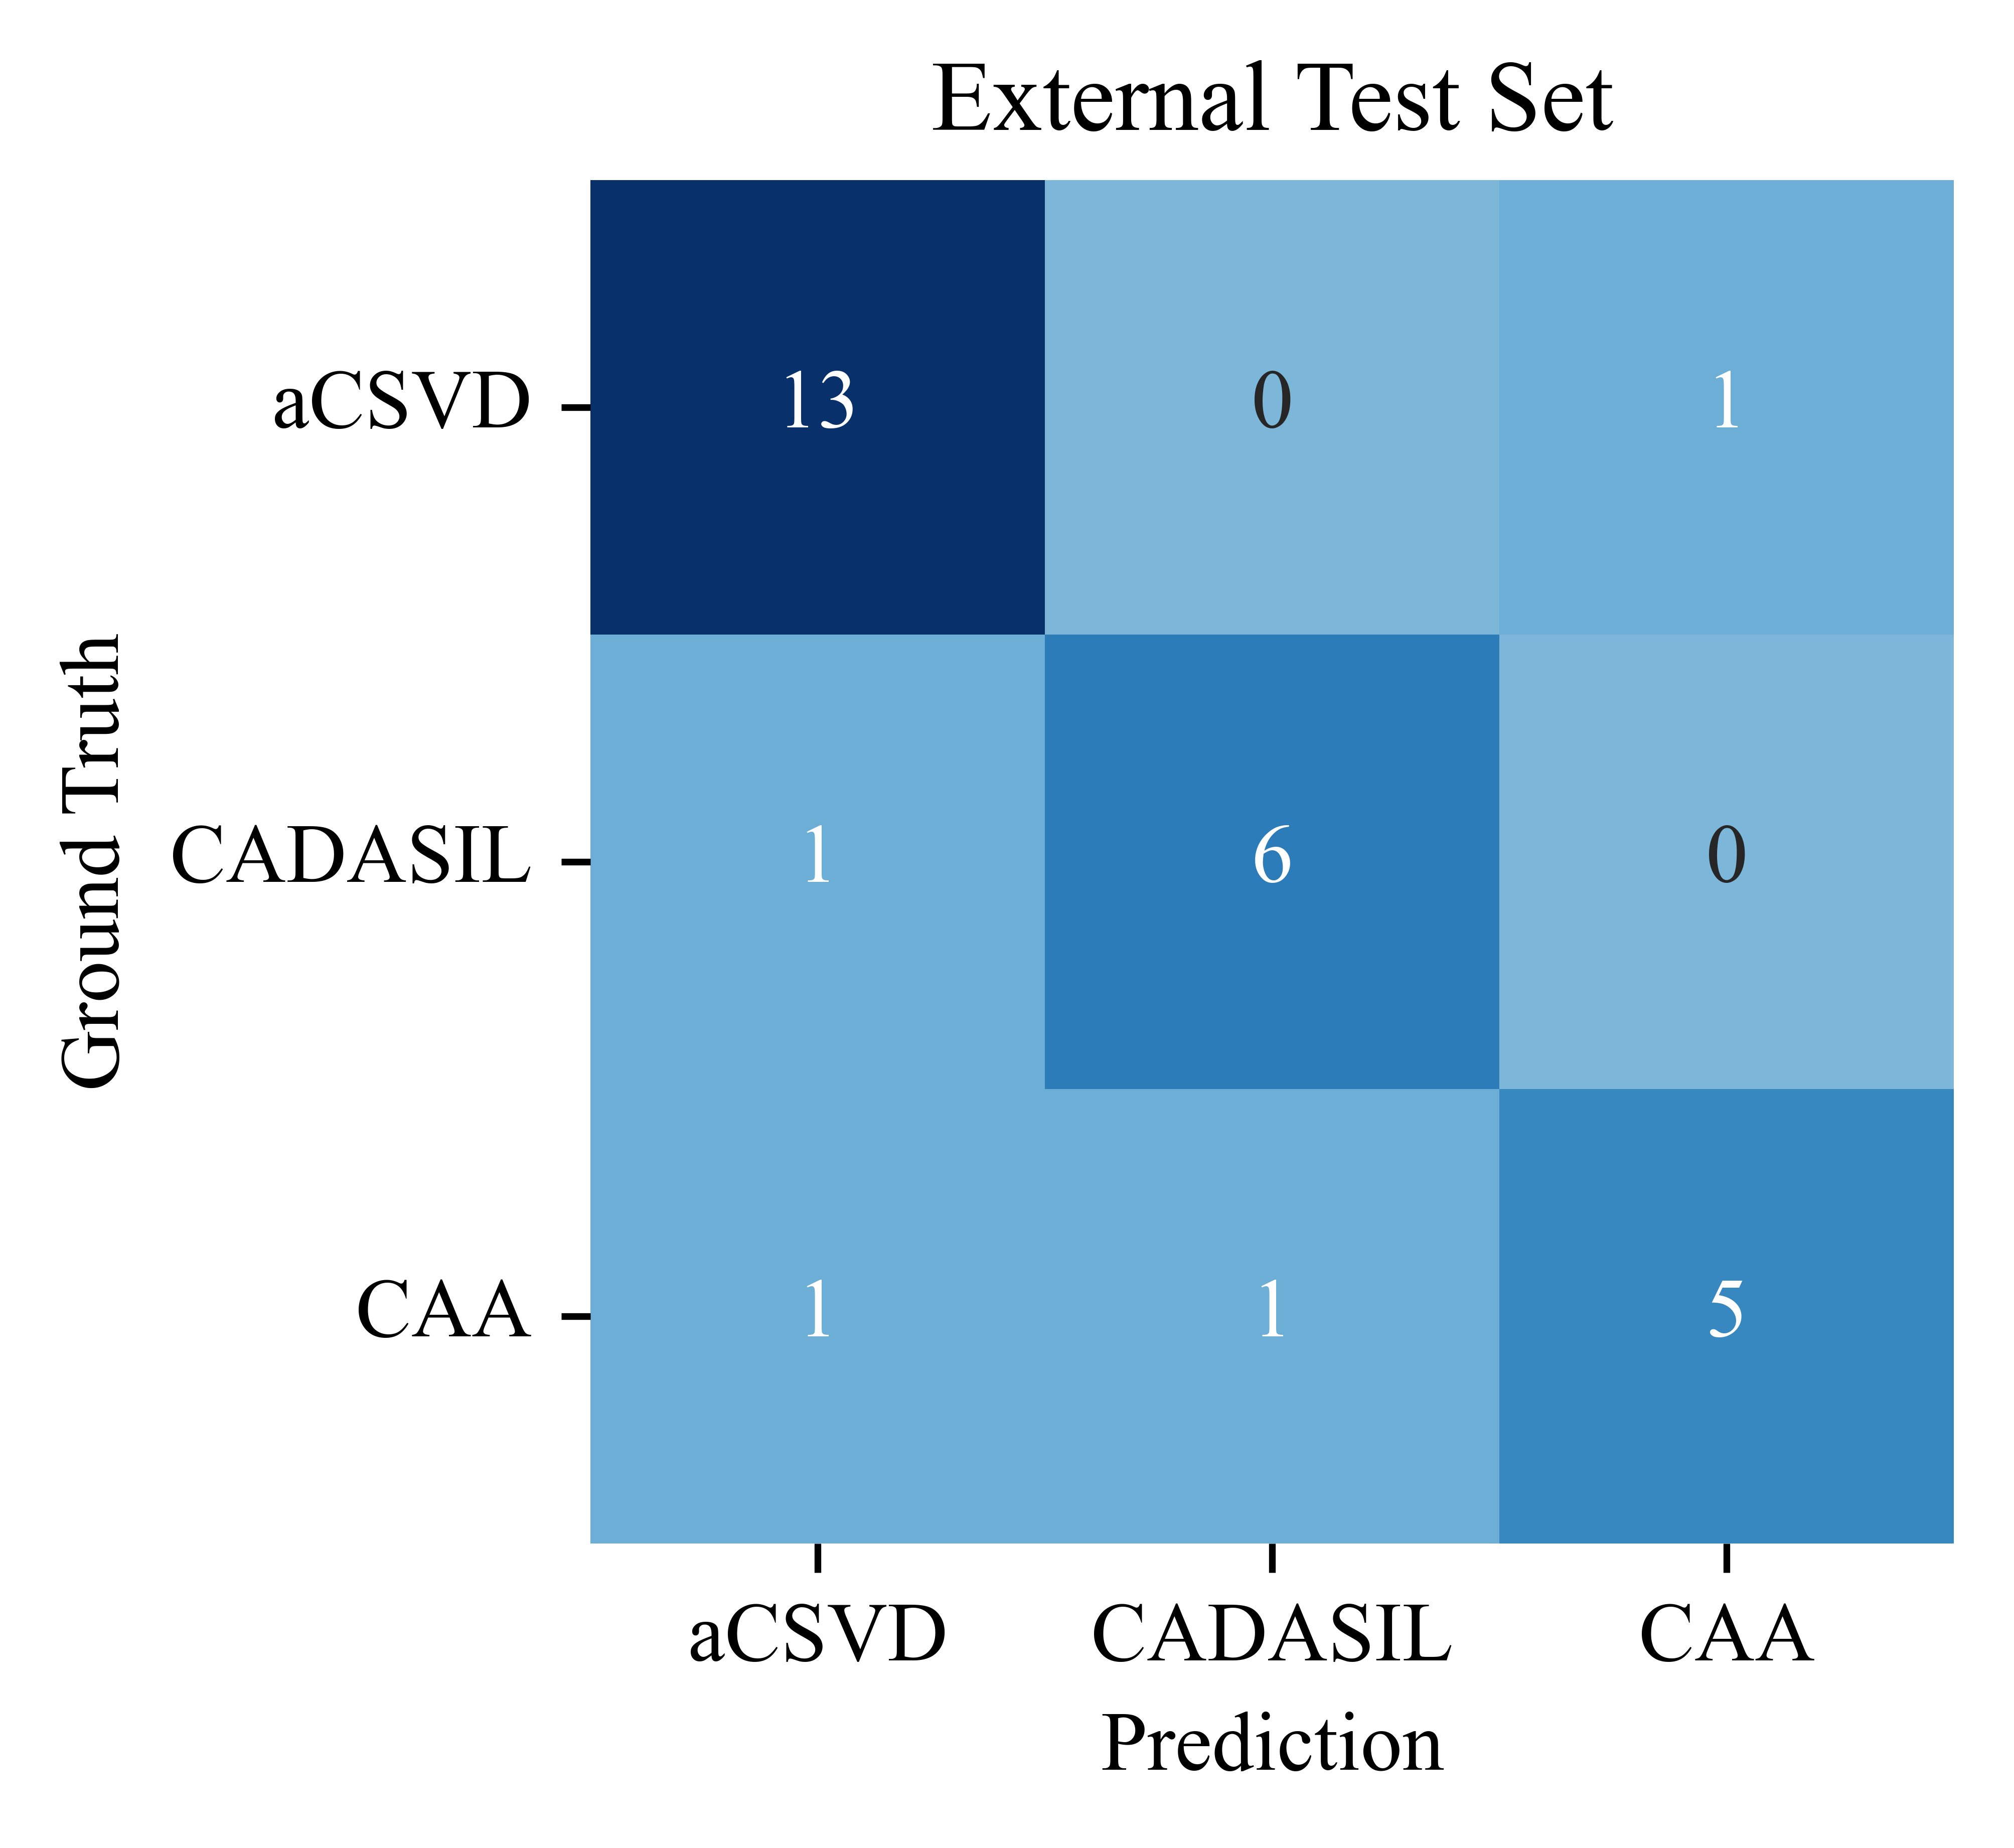

Dr_df.shape (28, 4)


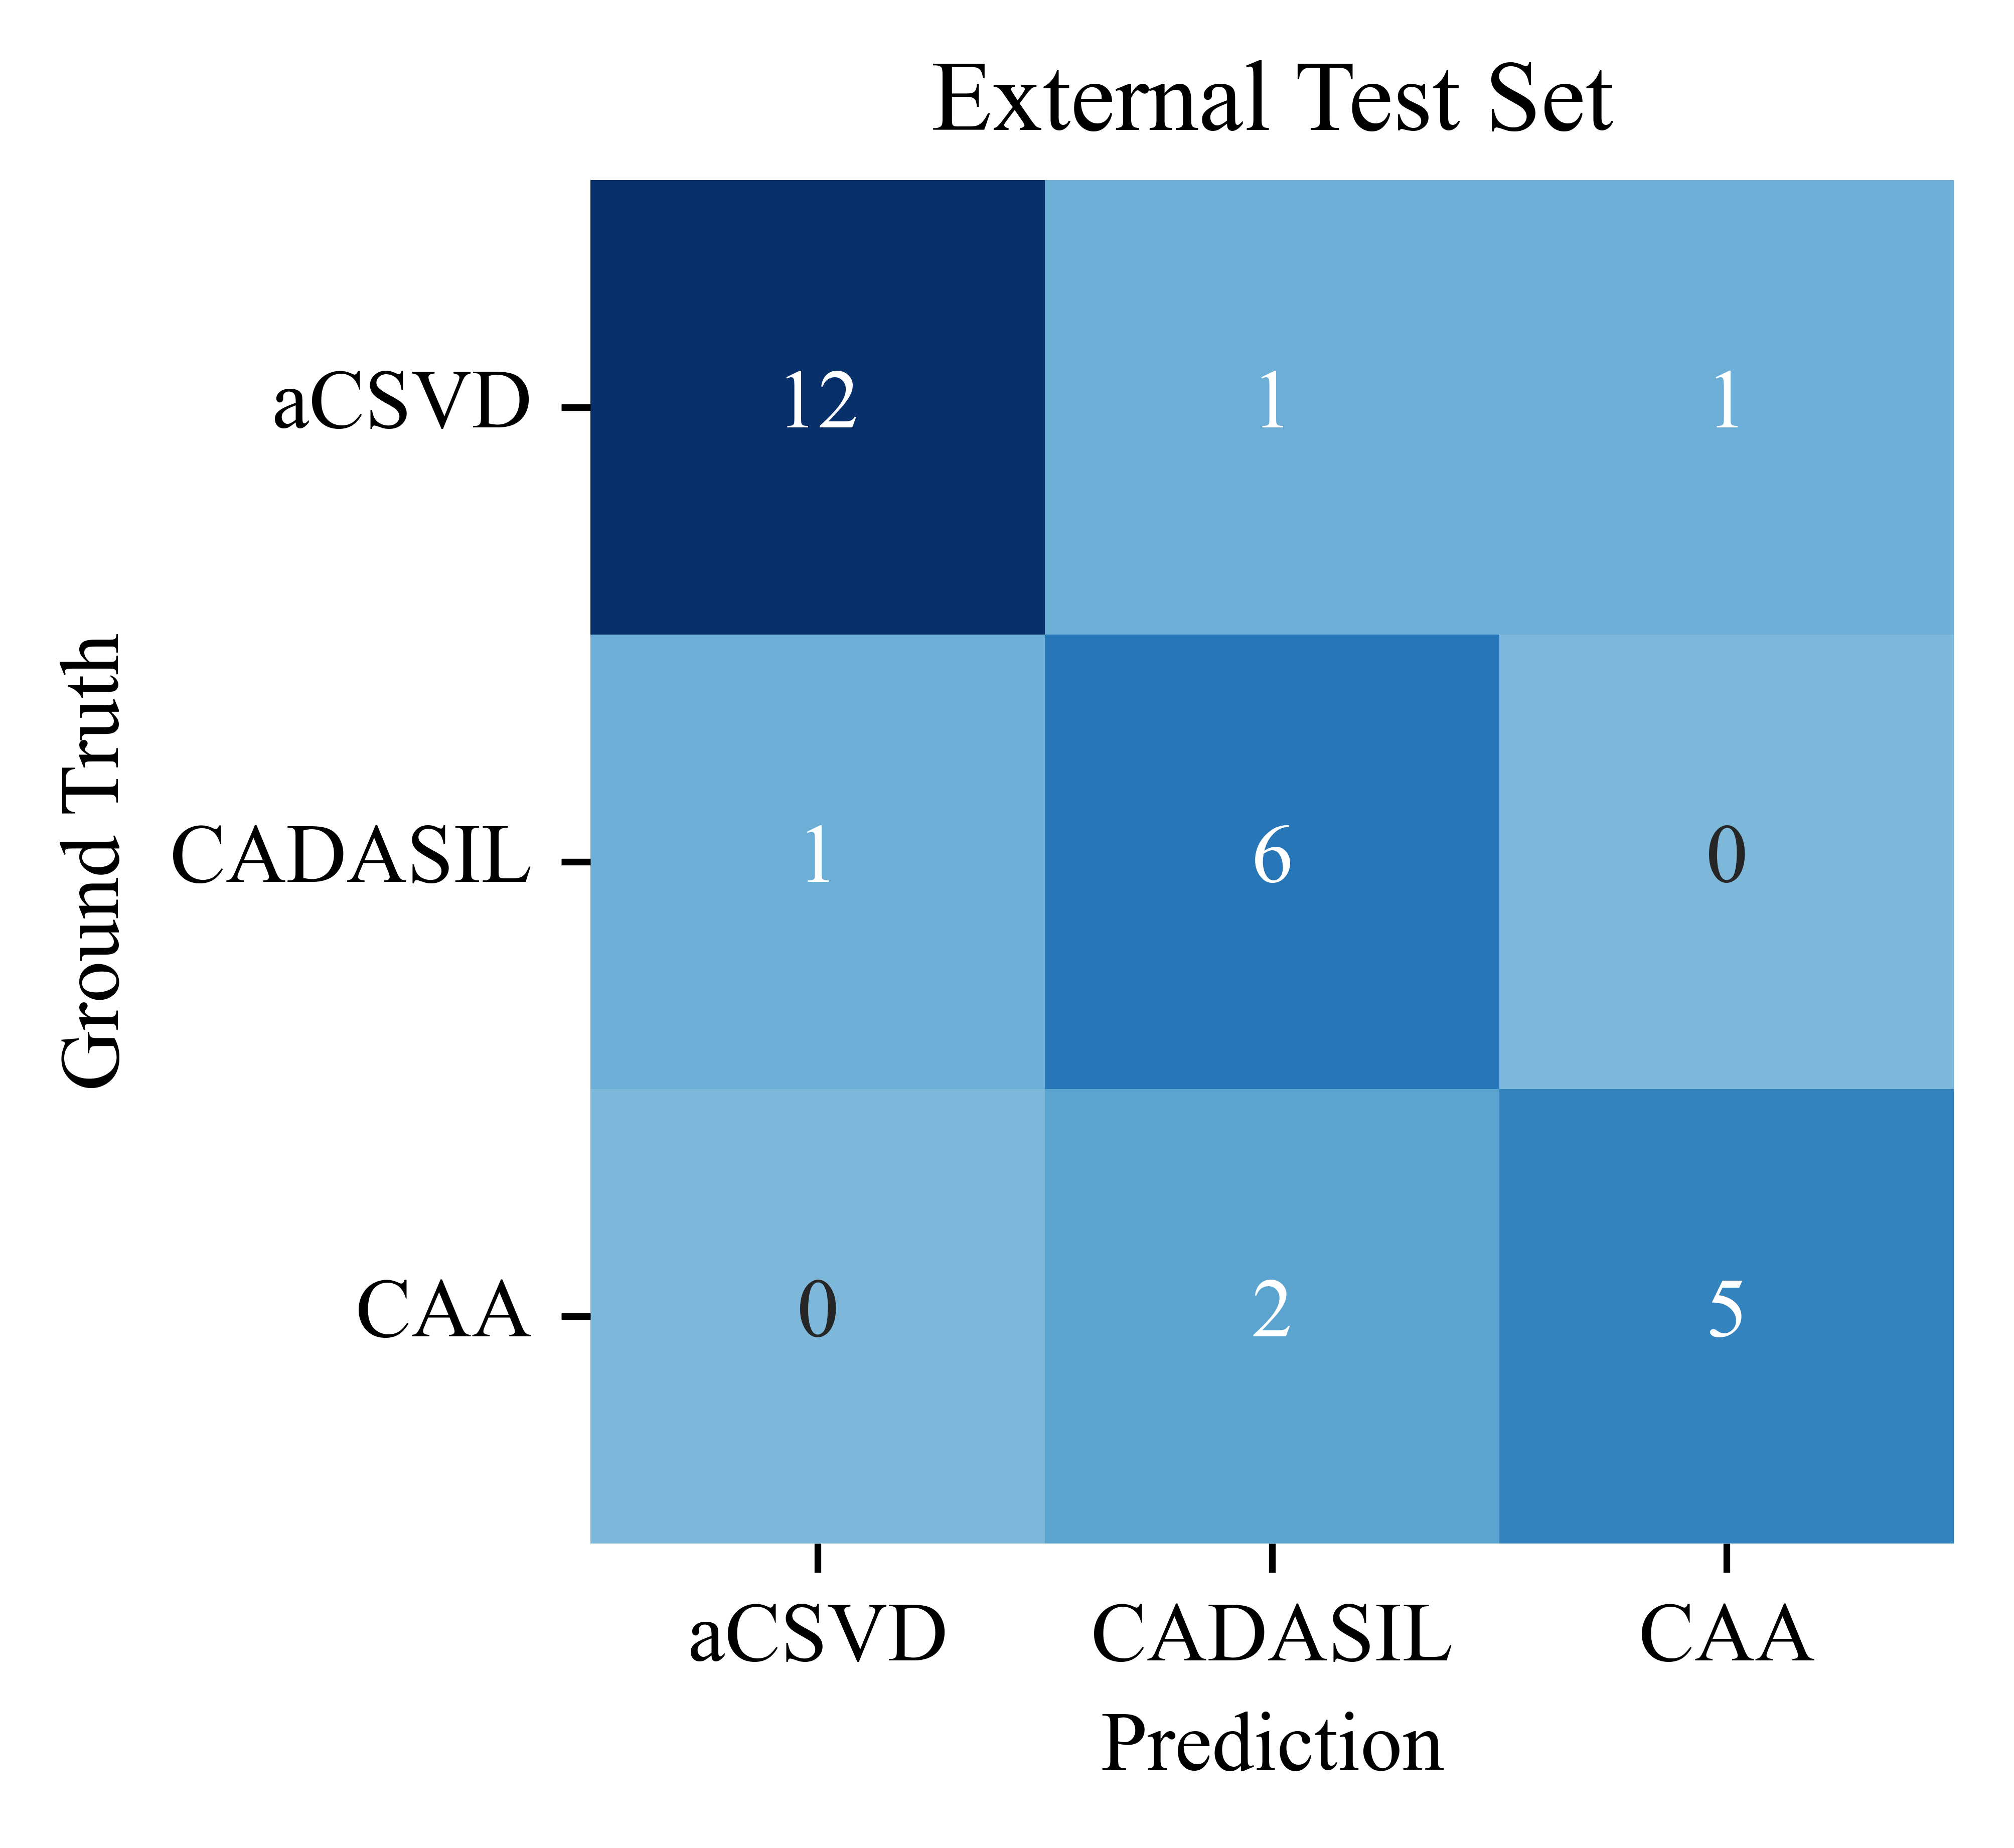

Dr_df.shape (28, 4)


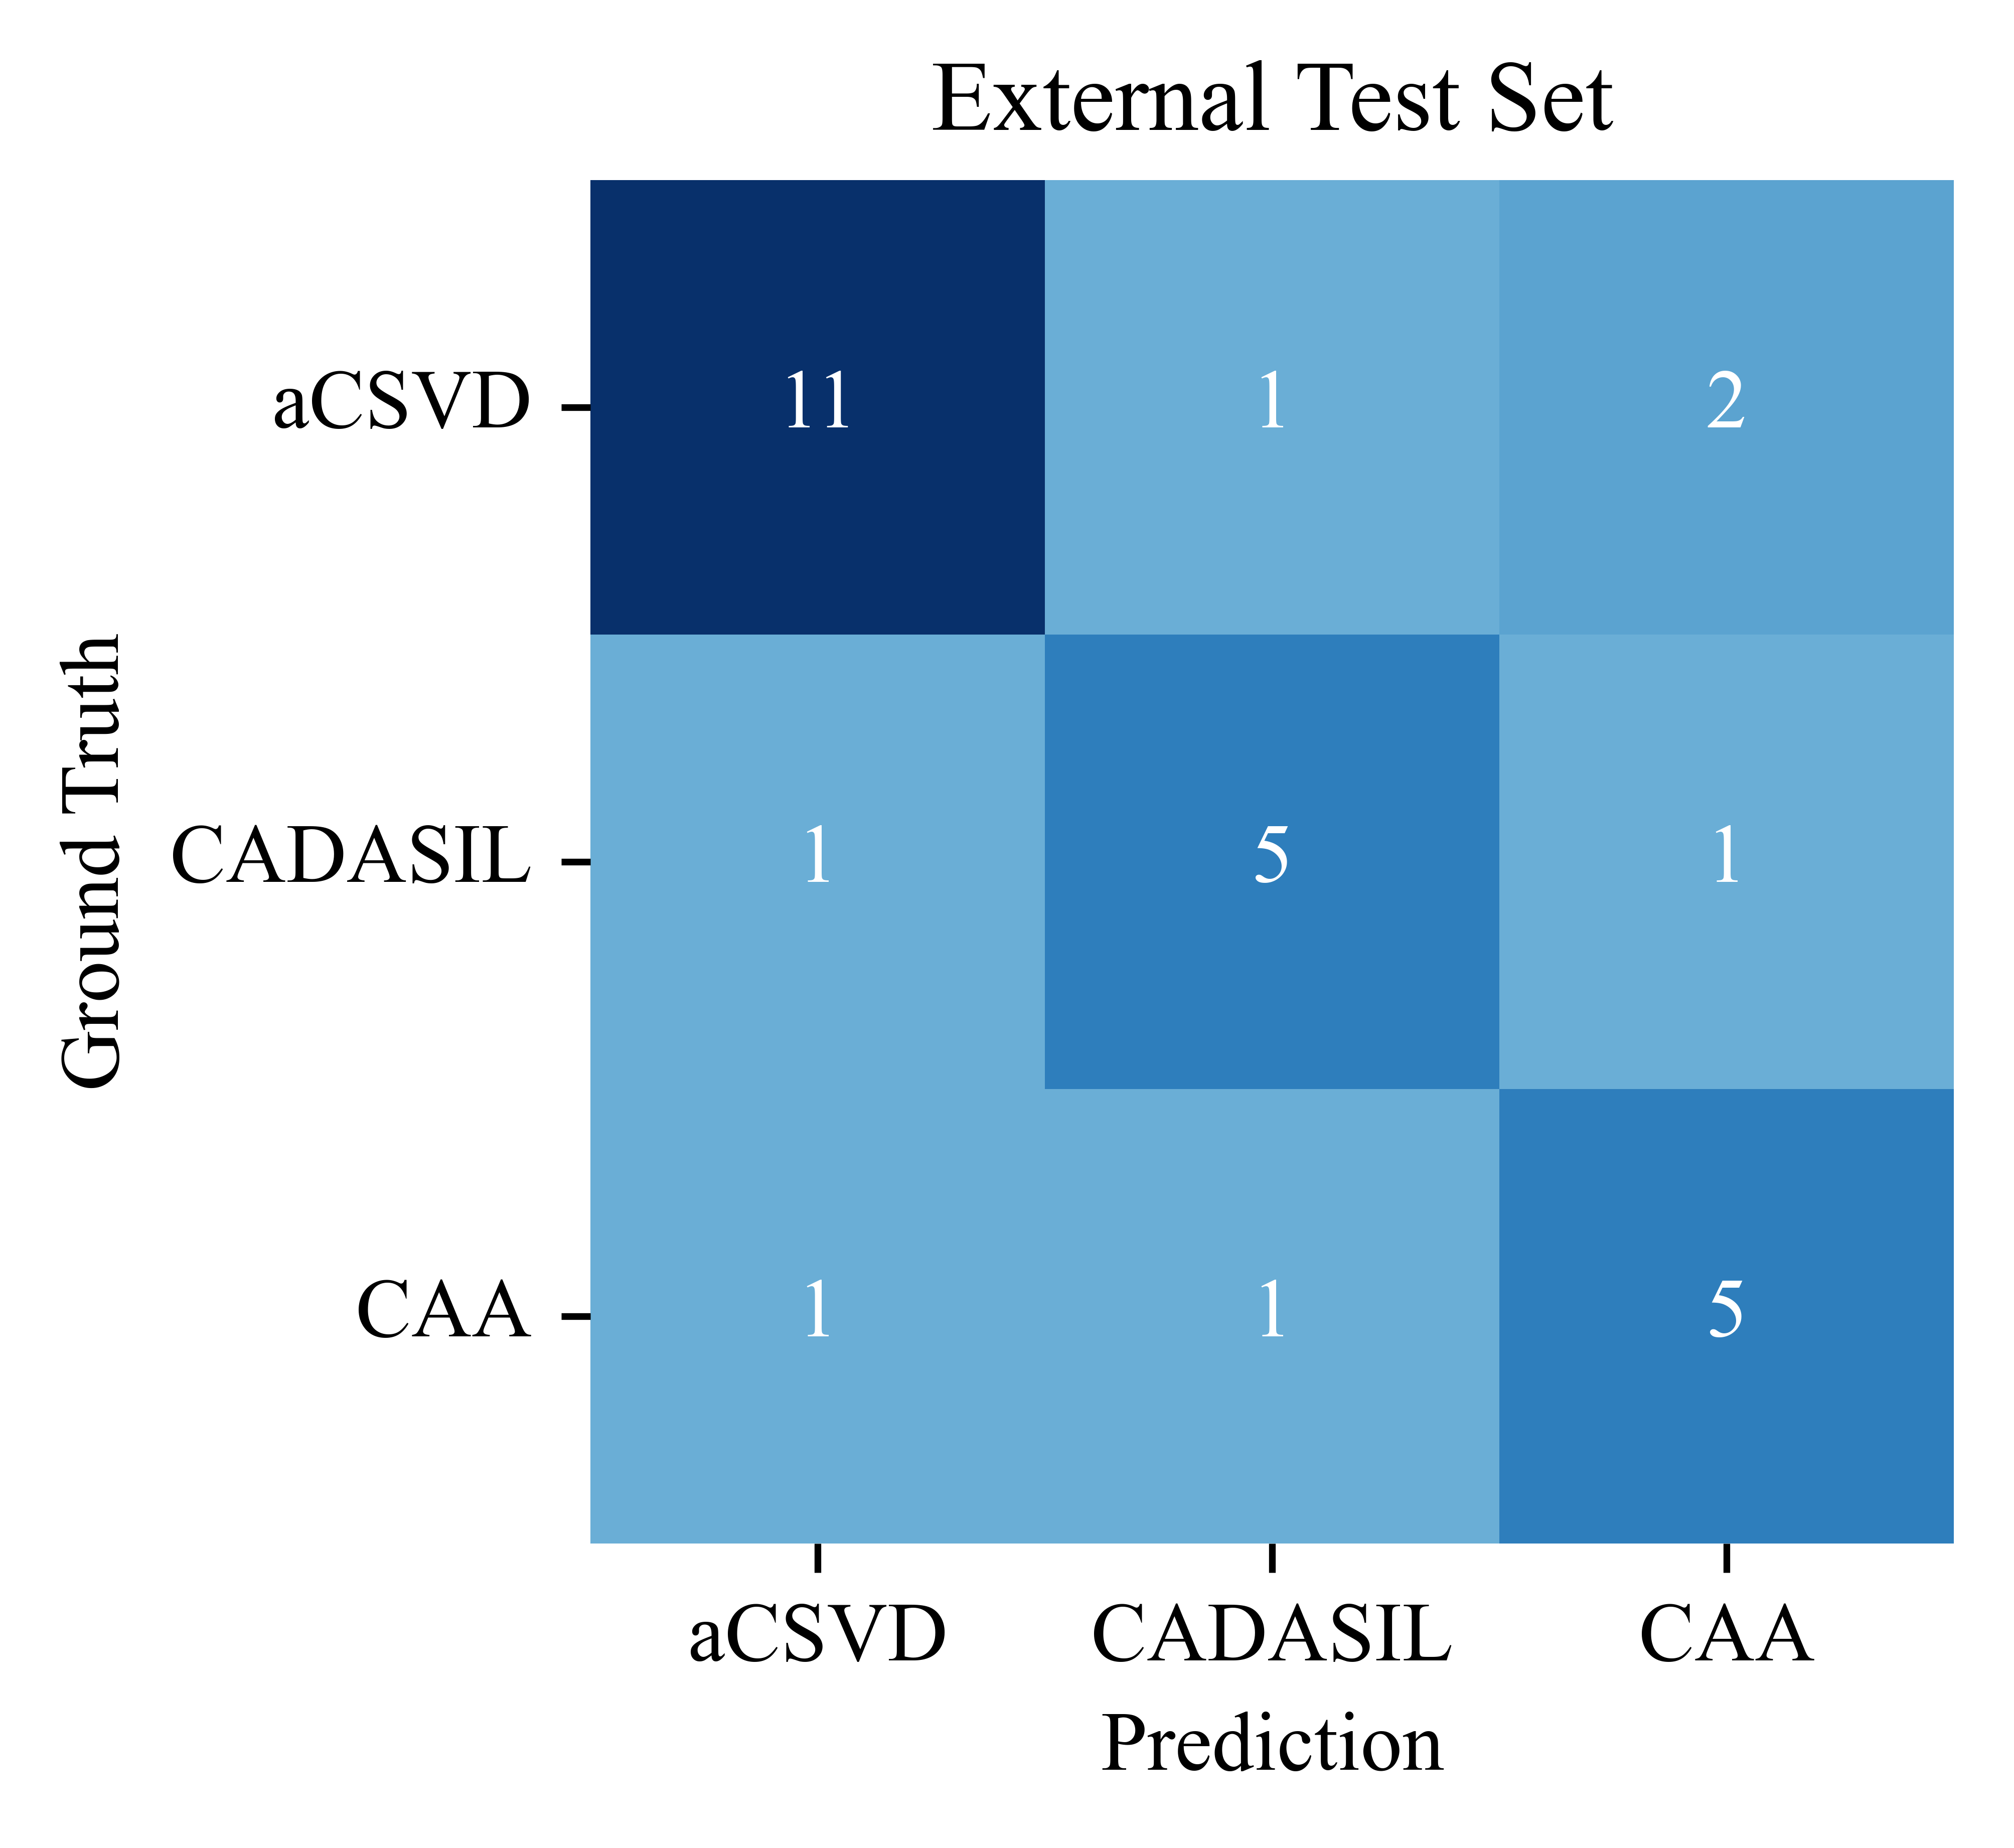

Dr_df.shape (28, 4)


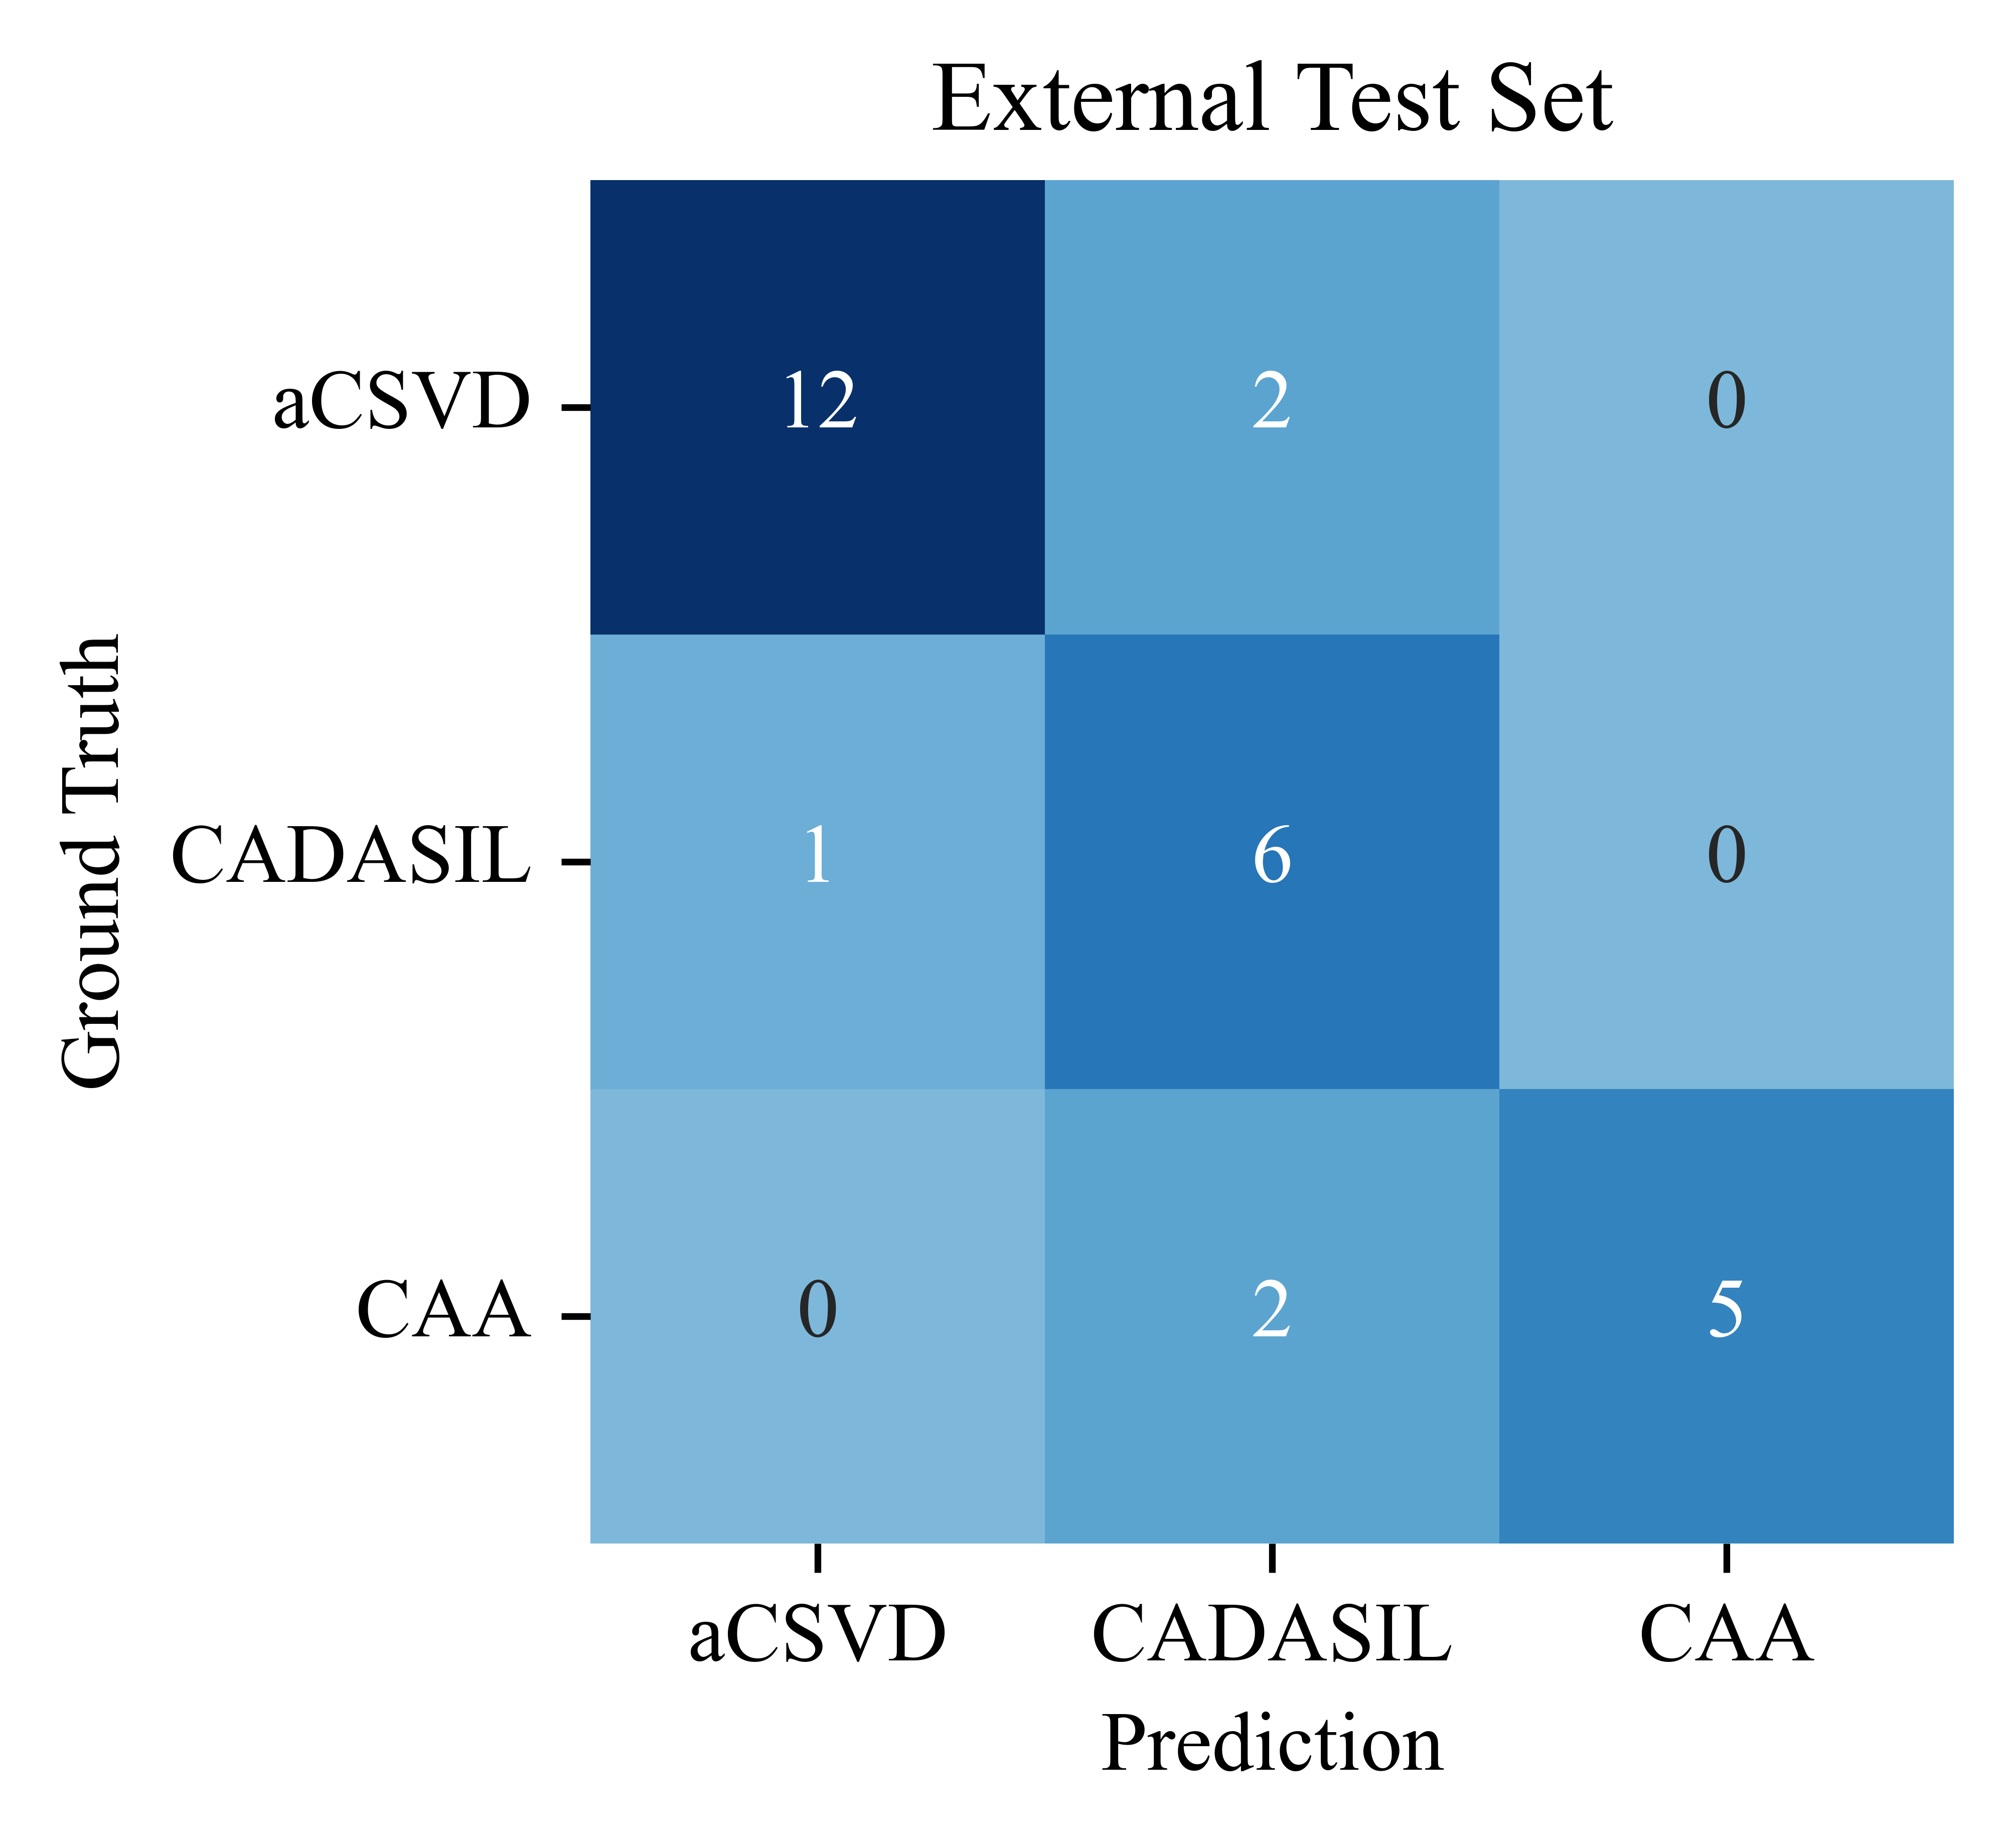

/opt/conda/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2098: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/opt/conda/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2099: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Dr_df.shape (28, 4)


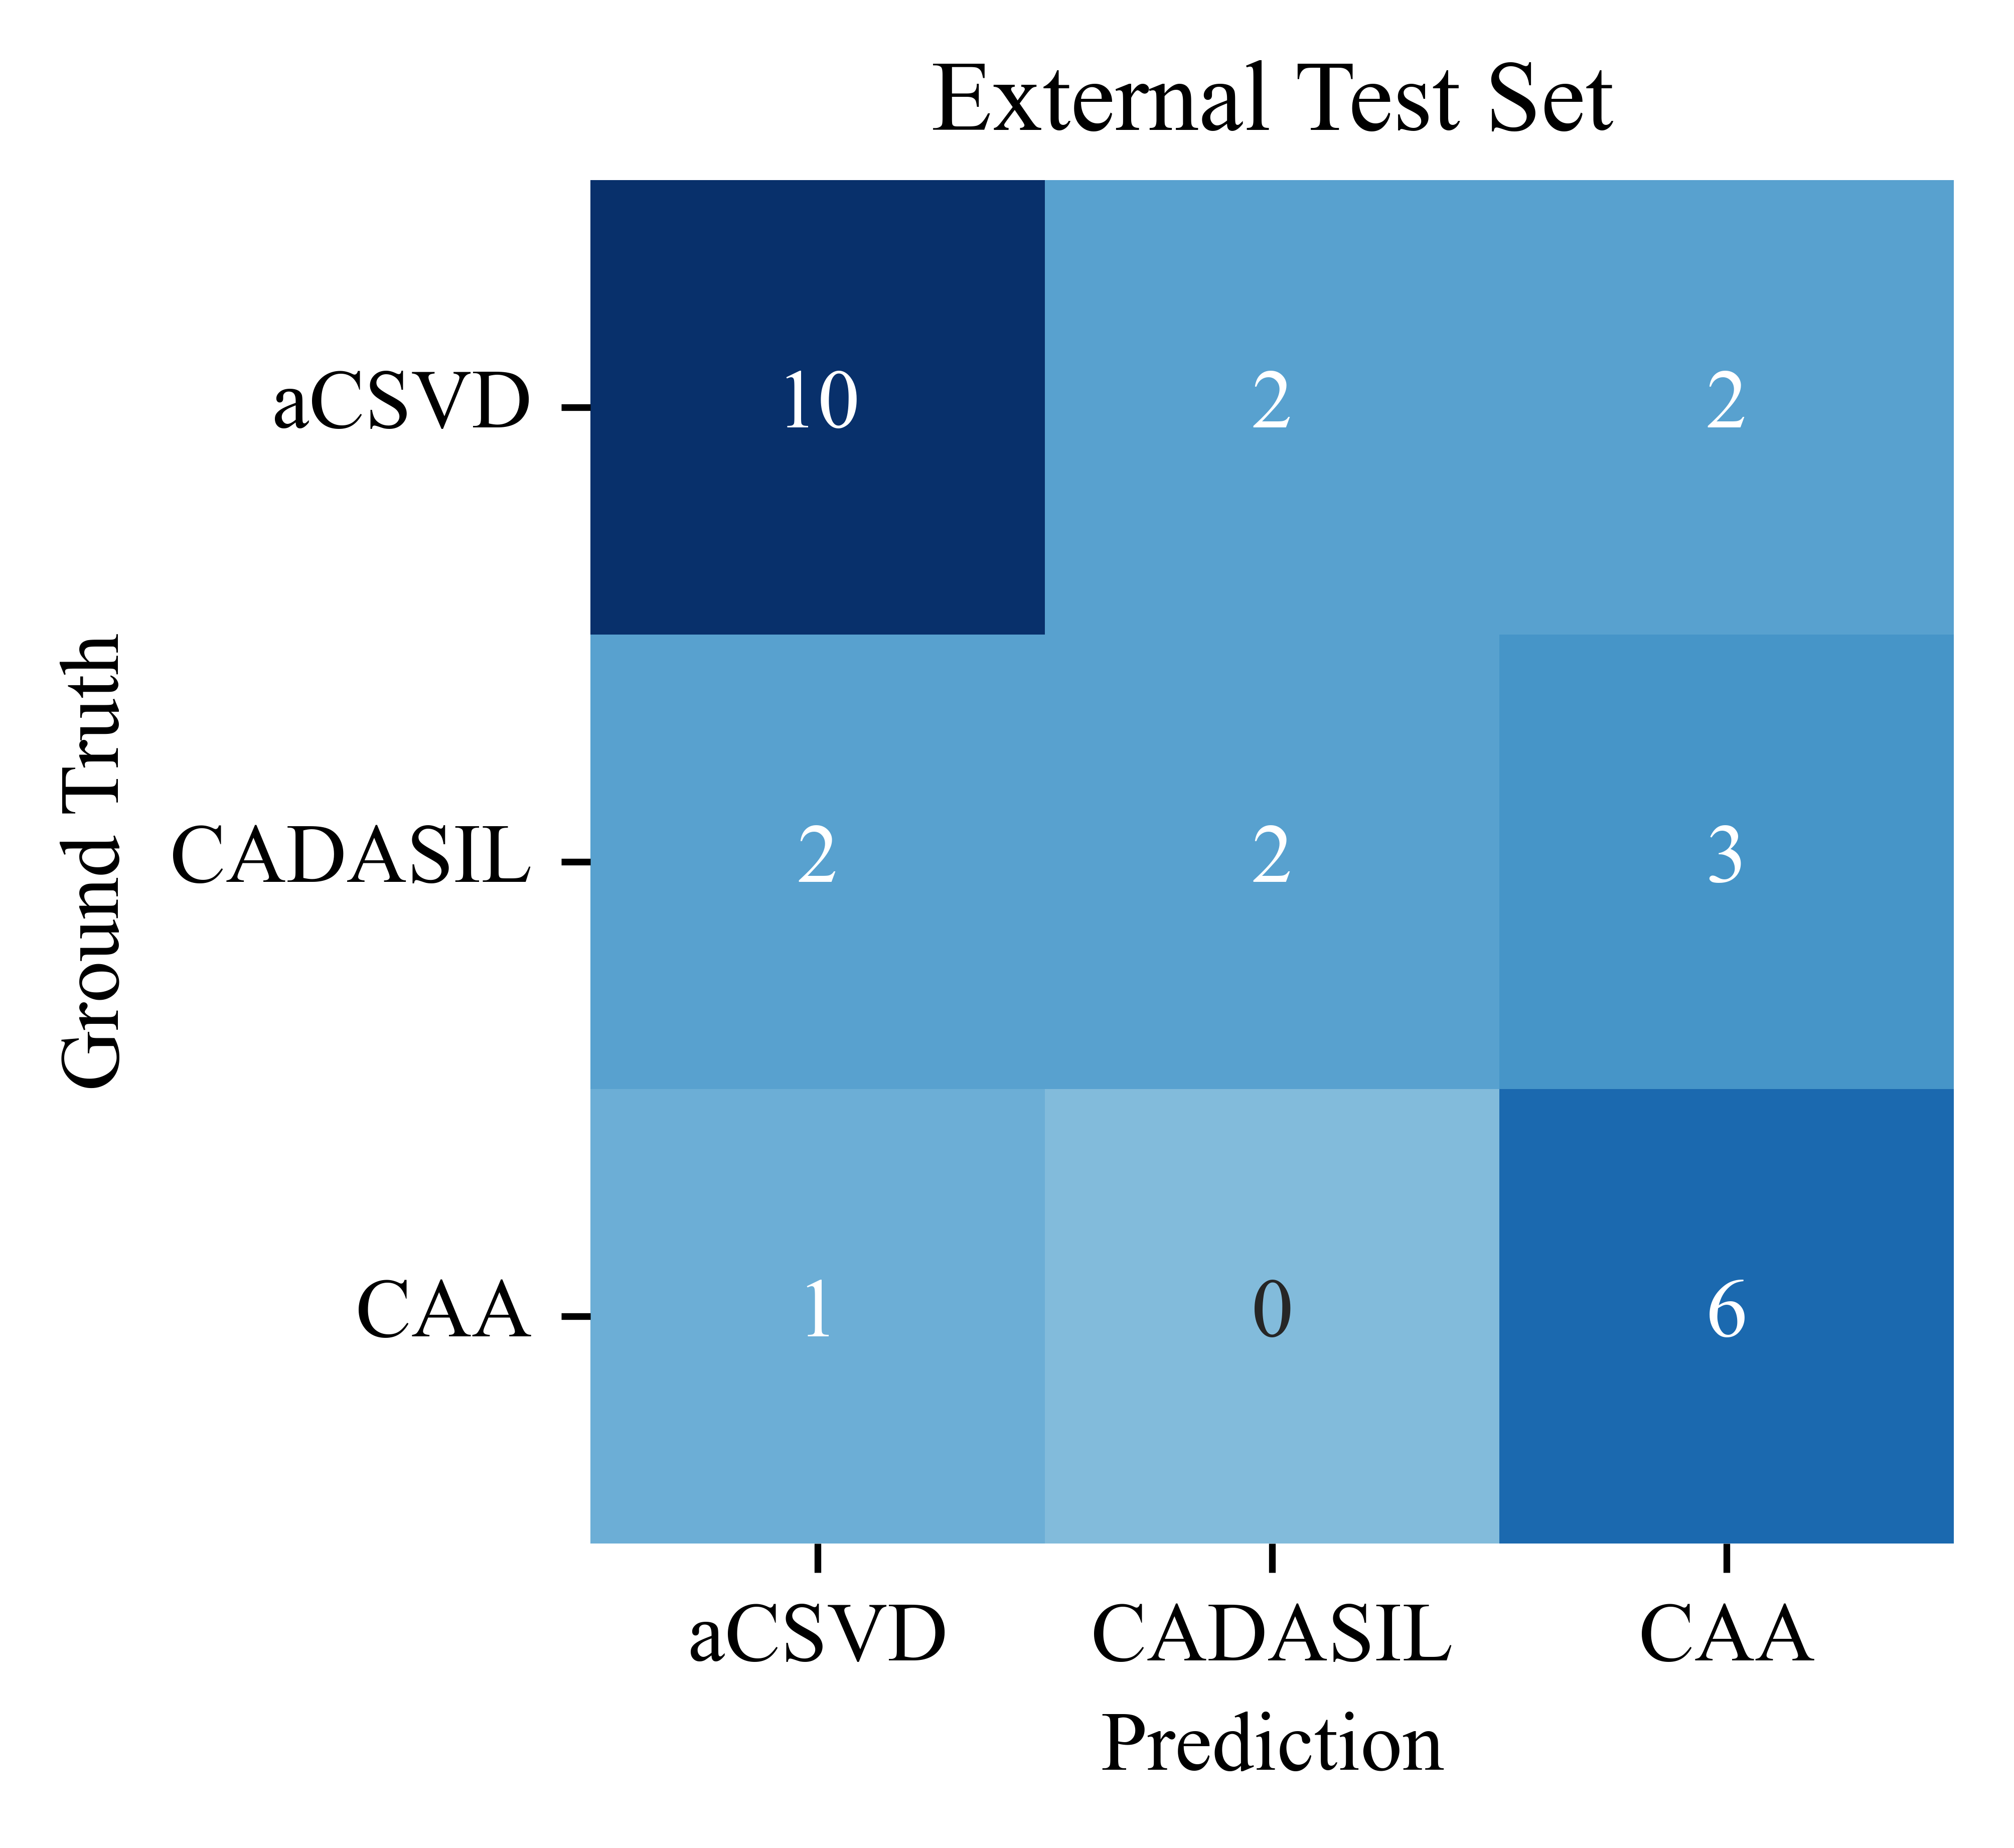

秦冰                           魏磊  \
aCSVD     0.892, 95%CI: 0.873 ~ 0.912  0.892, 95%CI: 0.877 ~ 0.906   
CADASIL   0.904, 95%CI: 0.880 ~ 0.927  0.857, 95%CI: 0.834 ~ 0.879   
CAA       0.833, 95%CI: 0.803 ~ 0.864  0.834, 95%CI: 0.800 ~ 0.867   
micro     0.893, 95%CI: 0.876 ~ 0.909  0.865, 95%CI: 0.848 ~ 0.883   
macro     0.877, 95%CI: 0.857 ~ 0.896  0.861, 95%CI: 0.842 ~ 0.879   
weighted  0.880, 95%CI: 0.861 ~ 0.900  0.868, 95%CI: 0.852 ~ 0.885   

                                  卢婷婷                          黄雪泓  \
aCSVD     0.820, 95%CI: 0.796 ~ 0.844  0.893, 95%CI: 0.874 ~ 0.912   
CADASIL   0.808, 95%CI: 0.781 ~ 0.836  0.835, 95%CI: 0.808 ~ 0.862   
CAA       0.785, 95%CI: 0.753 ~ 0.816  0.861, 95%CI: 0.830 ~ 0.892   
micro     0.811, 95%CI: 0.793 ~ 0.830  0.867, 95%CI: 0.848 ~ 0.887   
macro     0.804, 95%CI: 0.785 ~ 0.823  0.863, 95%CI: 0.842 ~ 0.884   
weighted  0.808, 95%CI: 0.789 ~ 0.827  0.870, 95%CI: 0.851 ~ 0.890   

                                   刘旭  
aCSVD     0.752, 95%CI: 0.724 ~ 0.780  
CADASIL   0.597, 95%CI: 0.567 ~ 0.626  
CAA       0.811, 95%CI: 0.782 ~ 0.840  
micro     0.734, 95%CI: 0.713 ~ 0.755  
macro     0.720, 95%CI: 0.698 ~ 0.742  
weighted  0.728, 95%CI: 0.705 ~ 0.750

In [6]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()

Dr_ROC = dict([])
Dr_ExtTestSet_report_dict = dict([])
Dr_names = params['Dr_names']#'陆正齐',


idxs = list(params['clses_name'].keys())[:3]+['micro','macro','weighted']
Dr_ext_test_AUC_df = pd.DataFrame( 
    columns=Dr_names, 
    index=idxs,
)

for Dr_name in Dr_names:
    # 读取数据并预处理
    Dr_df = pd.read_excel(params['filepath_Human_prediction'],sheet_name=Dr_name)
    
#     Dr_df['诊断'] = Dr_df['诊断'].apply(lambda x: x.upper())
#     Dr_df['Ground truth'] = Dr_df['Ground truth'].apply(lambda x: x.upper())
    Dr_df = Dr_df[ Dr_df['诊断'].apply(lambda x: x in params['clses_name'].keys()) ]
    Dr_df['诊断'] = Dr_df['诊断'].apply(lambda x: params['clses_name'][x])
    Dr_df['Ground truth'] = Dr_df['Ground truth'].apply(lambda x: params['clses_name'][x])
    print( "Dr_df.shape", Dr_df.shape )
    
    
    # 混淆矩阵
    import seaborn as sns
    from sklearn.metrics import confusion_matrix
    y_true = Dr_df['Ground truth']
    y_pred = Dr_df['诊断']
    cm = confusion_matrix(y_true,y_pred).astype(int)
    fig = plt.figure(dpi=params['dpi'],figsize=(3,3))
    ax = sns.heatmap(cm,annot=True,fmt='d',center=True,cmap='Blues',cbar=False)
    ax.set_aspect('equal','box')
    ax.set_xticks(ticks=[0.5,1.5,2.5],labels=['aCSVD','CADASIL','CAA'],rotation='horizontal')
    ax.set_yticks(ticks=[0.5,1.5,2.5],labels=['aCSVD','CADASIL','CAA'],rotation='horizontal')
    ax.set_xlabel('Prediction')
    ax.set_ylabel('Ground Truth')
    ax.set_title('External Test Set')
    plt.savefig(
        params['filepath_save_Dr_CM'].replace('.tiff','_{}.tiff'.format(Dr_name)),
        dpi=params['dpi'],
        bbox_inches='tight'
    )
    plt.show()
    
    # ROAUC 
    y_pred_onehot = enc.fit_transform(y_pred.values[:,np.newaxis]).toarray()
    Dr_AUC_score_df = AUC_CI_score(y_true=y_true.values, y_prob=y_pred_onehot, ci=95)
    Dr_AUC_score_df.rename(index=dict( (cls_index,cls_name) for cls_name, cls_index in list(params['clses_name'].items())[:3] ), inplace=True)
    Dr_ext_test_AUC_df.loc[:,Dr_name] = Dr_AUC_score_df.values
    
    # ROC坐标用于后续绘制ROC曲线图
    y_true_onehot = enc.fit_transform(y_true.values[:,np.newaxis]).toarray()
    Dr_ROC[Dr_name] = get_roc(y_true_onehot,y_pred_onehot,n_classes=3)# 求医生的AUC意义不大,因为医生诊断结果不是概率值

    # 统计指标: precision/recall/f1score_accuracy/micro/macro    
    y_true = y_true.values # numpy array
    y_pred = y_pred.values # numpy array
    report_CI_df = classification_CI_report(y_true=y_true, y_pred=y_pred, ci=95)
    Dr_ExtTestSet_report_dict[Dr_name] = report_CI_df

with pd.ExcelWriter(params['filepath_save_Dr_Metrics']) as xlsx:
    Dr_ext_test_AUC_df.to_excel(xlsx, sheet_name="医生的AUC")
    for Dr_name in Dr_names:
        Dr_ExtTestSet_report_dict[Dr_name].to_excel(xlsx, sheet_name=Dr_name)

display(Dr_ext_test_AUC_df)

# 单模型

## CV内部测试集串联起来

### 读取数据，画ROC曲线

[22, 23]

[]

[19, 20]

[17, 21]

[21, 22]

[15, 14]

[19, 20]

[17, 4]

[22, 23]

[32, 17]

[22, 23]

[17]

[11]

[22]

[22]

[29, 20]

[20]

[24, 26]

[23, 24]

[19, 15]

aCSVD  CADASIL     CAA   micro   macro  weighted
Fold 0:   0.9121   1.0000  0.9250  0.9239  0.9622    0.9505
Fold 1:   0.8242   0.7419  0.8375  0.8577  0.8221    0.8409
Fold 2:   0.8571   0.8917  0.8133  0.8590  0.8720    0.8688
Fold 3:   0.8893   0.8167  0.8667  0.8767  0.8823    0.8935
Fold 4:   0.9500   0.9500  0.9292  0.8910  0.9511    0.9519
Fold 5:   0.8821   0.6000  0.9292  0.9010  0.8267    0.8785
Fold 6:   0.8769   1.0000  0.8783  0.8976  0.9314    0.9079
Fold 7:   0.9308   0.9556  0.9217  0.8972  0.9470    0.9428
Fold 8:   0.9115   0.9111  0.9087  0.9164  0.9241    0.9268
Fold 9:   0.8423   0.6222  0.9261  0.8664  0.8330    0.8721

{0: 0.8667, 1: 0.8336, 2: 0.8629, 'micro': 0.8833, 'macro': 0.8571, 'weighted': 0.865}


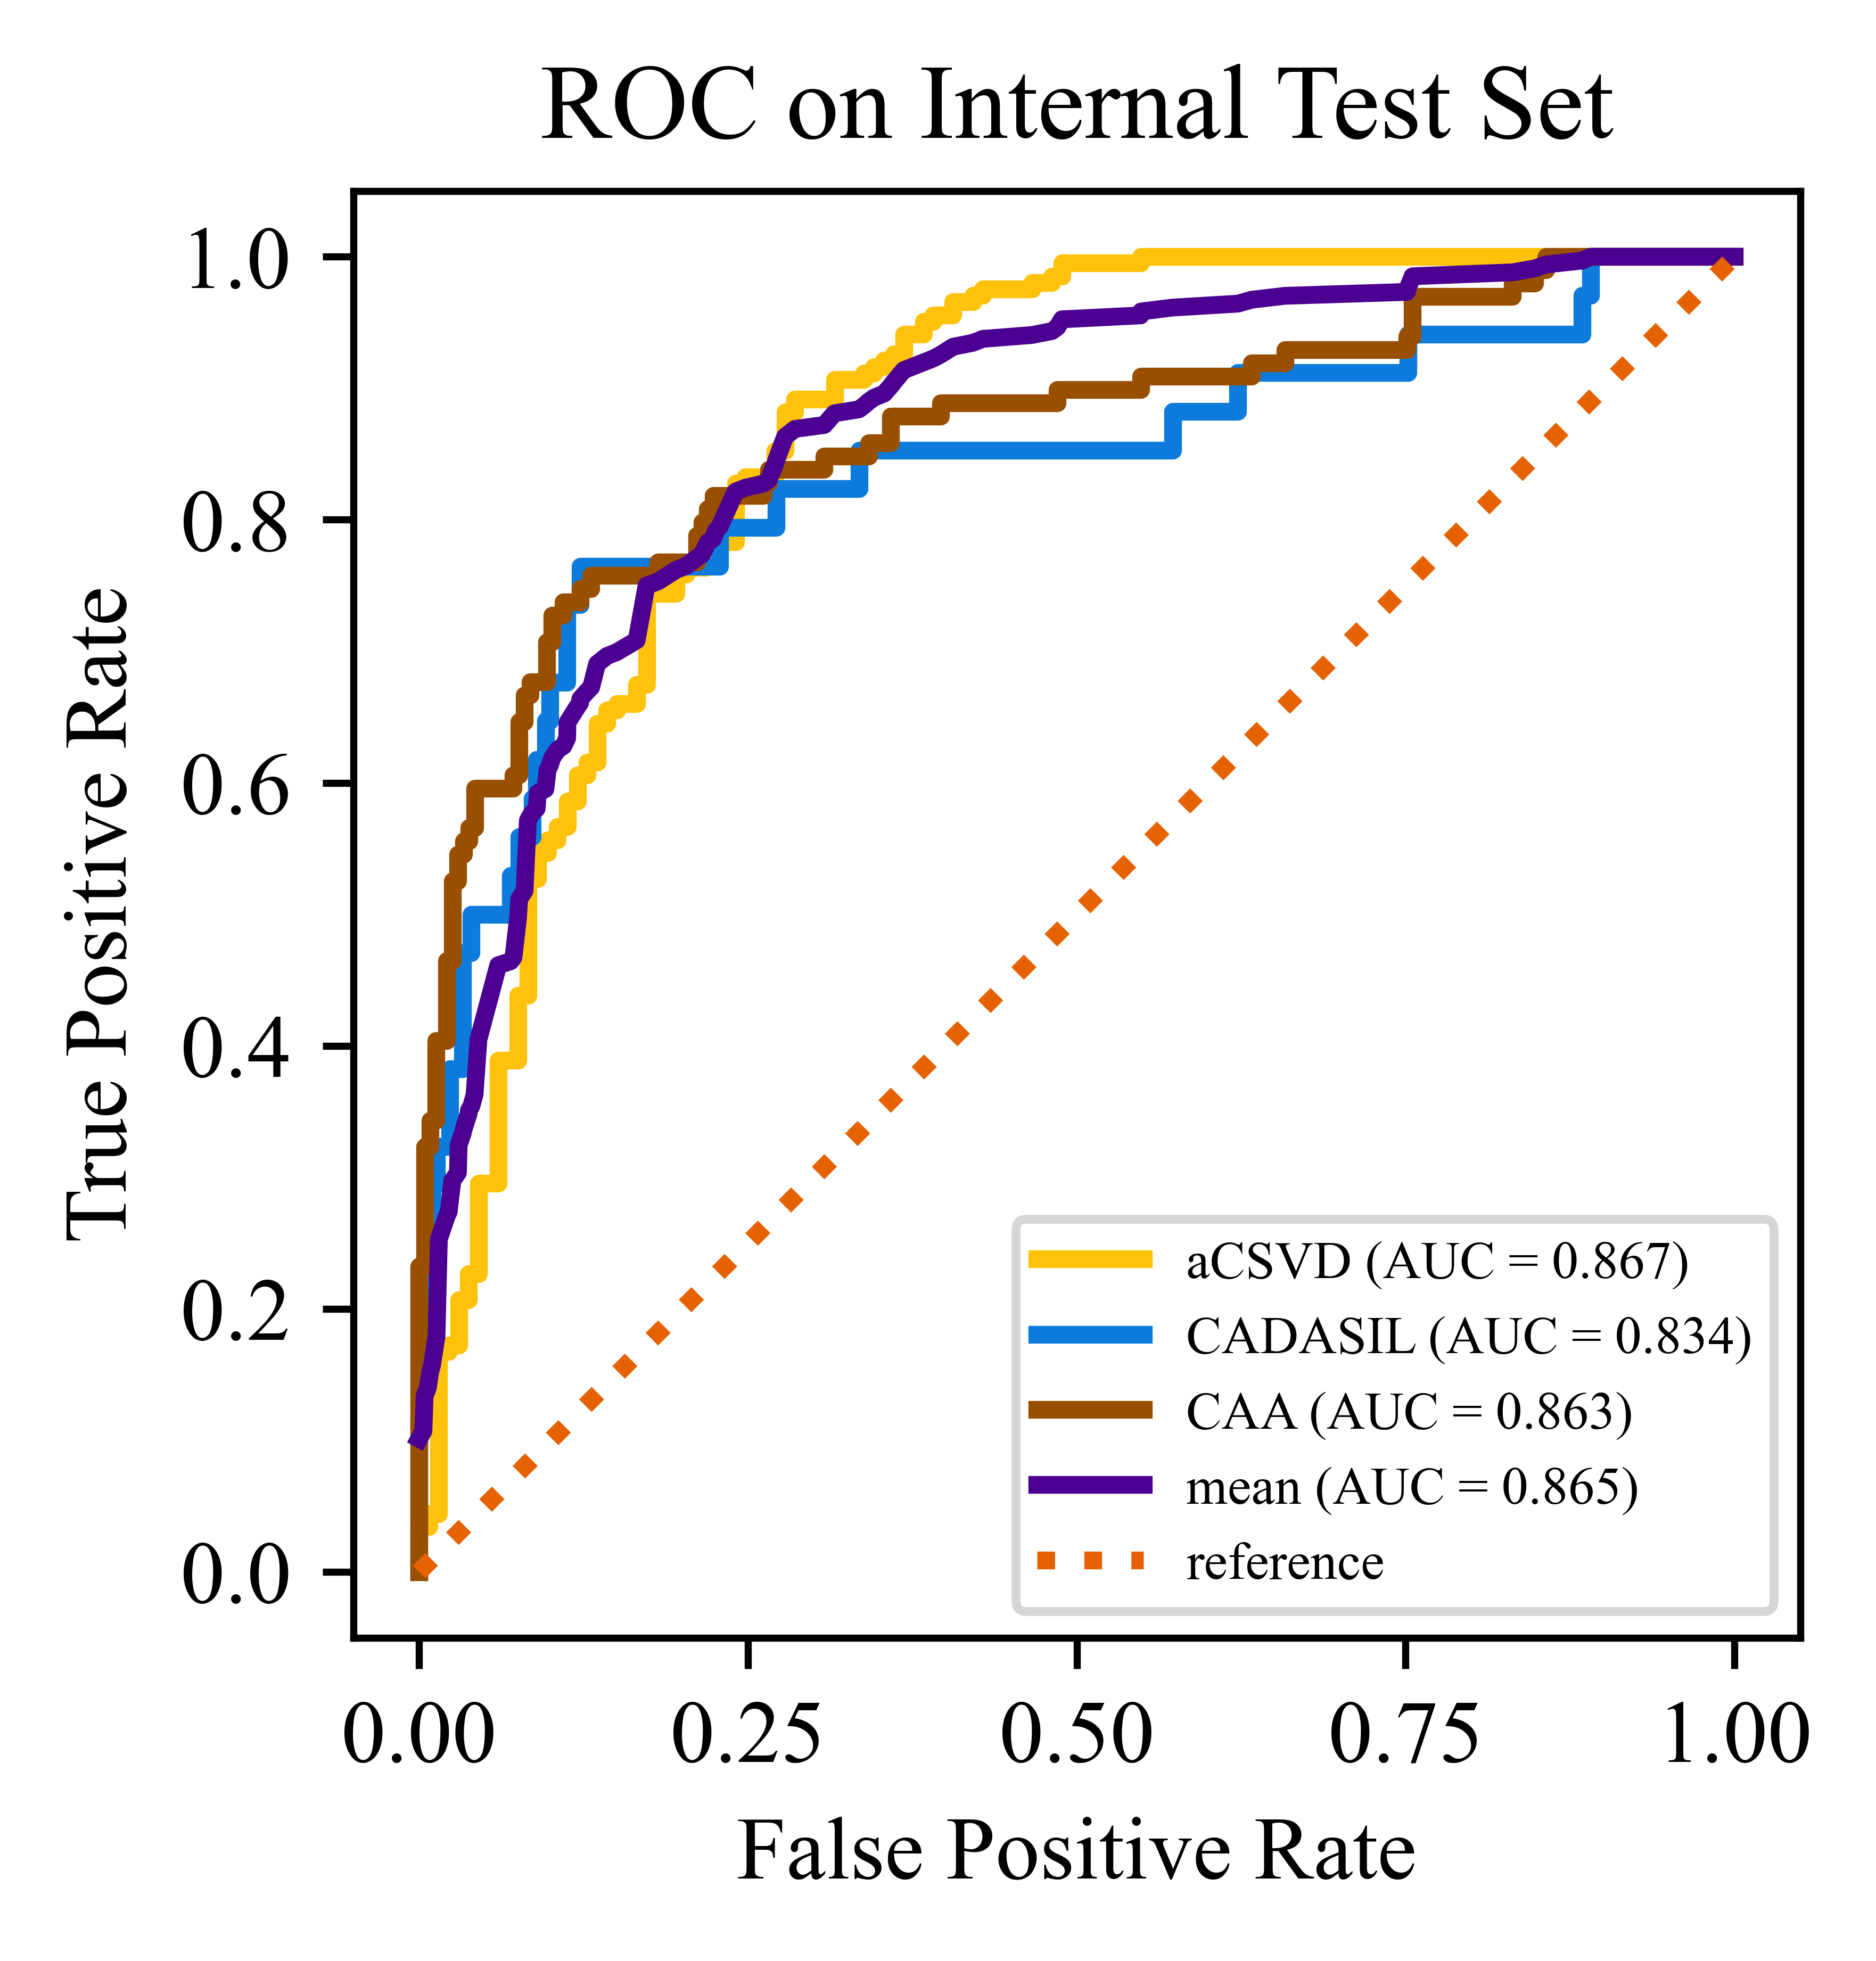

In [7]:
import pickle
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()

roc_auc = dict([])
proba_cv = dict([]) 
label_cv = dict([])
# rb是2进制编码文件，文本文件用r
for k in range(10):
    pkl_filepath = params['pkl_filepath'].format(k)
#     pkl_filepath = './results/SWS_withMask_3category_ZSSYandMMSY_20220902_s1/split_{}_results.pkl'.format(k)
    f = open(pkl_filepath,'rb')
    data = pickle.load(f)

    filepath = list(data.keys())
    label_list = [item['cls_label'] for item in list(data.values())]
    proba_list = [item['cls_prob'] for item in list(data.values())]
    proba = np.array(proba_list).squeeze()
    
    y_true = enc.fit_transform( np.array(label_list).reshape(-1, 1) )
    y_true = y_true.toarray()
    
    #####################################################################
    import random
    random.seed(1024)
    # 漏检
    err_i = []
    for i,(y,y_) in enumerate(zip(np.argmax(y_true,1), np.argmax(proba,1))):
        if y==1 and y_!=y:
            err_i.append(i)
    err_i = random.sample(err_i,min(2,len(err_i)))# 1
    display(err_i)
    for i in err_i:
        proba[i,1] += 0.2
        proba[i,:] /= proba[i,:].sum()
    # 假阳    
    err_i = []
    for i,(y,y_) in enumerate(zip(np.argmax(y_true,1), np.argmax(proba,1))):
        if y!=1 and y_==1:
            err_i.append(i)
    err_i = random.sample(err_i,min(2,len(err_i)))# 1
    display(err_i)
    for i in err_i:
        proba[i,1] -= 0.2
        proba[i,:] /= proba[i,:].sum()
    #####################################################################
    
    fpr, tpr, roc_auc = get_roc(y_true=y_true, y_score=proba, n_classes=3)
    if k==0:
        cv_test_roc_auc_df = pd.DataFrame(roc_auc,index=['Fold {}: '.format(k)])
    else:
        cv_test_roc_auc_df = pd.concat( [cv_test_roc_auc_df,pd.DataFrame(roc_auc,index=['Fold {}: '.format(k)])], axis=0)

    proba_cv['fold_{}'.format(k)] = proba
    label_cv['fold_{}'.format(k)] = label_list
    
cv_test_roc_auc_df.rename(columns={0: 'aCSVD', 1: 'CADASIL', 2: 'CAA'},inplace=True)
display( cv_test_roc_auc_df )

label = []
for i, (fold,label_k) in enumerate(label_cv.items()):
    proba_k = proba_cv[fold]
    label += label_k
    if i==0:
        proba = proba_k
    else:
        proba = np.concatenate((proba, proba_k), axis=0)

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y_true = enc.fit_transform(np.array(label).reshape(-1, 1))
y_true = y_true.toarray()

fpr, tpr, roc_auc = get_roc(y_true=y_true, y_score=proba, n_classes=3)
print(roc_auc)


########### 画图：###########
import matplotlib.pyplot as plt
# 新建一块画布
fig,ax = plt.subplots(1,1,dpi=params['dpi'],figsize=(3,3))
ic = 0 # 颜色序号
# 画测试集的roc曲线
tmp_dict = params['clses_name']
tmp_dict.update({'mean':'weighted'})
ic = 0# 记录颜色序号
############################################################################################################
# 由于boostrap方法统计95%CI，存在一定随机性，倒是每次计算出来的数值最后一1~2位小数不固定，所以在此手动定义数值大小，用于绘图
AUC_SCORE = {"aCSVD":0.867, "CADASIL":0.834, "CAA":0.863, "mean":0.865}
############################################################################################################
for label_name, key in tmp_dict.items():
    plt.plot(fpr[key], tpr[key],
             lw=2, 
             label='{} (AUC = {:.3f})'.format(label_name, roc_auc[key]),
             color=params['color_list'][ic]
            )
    ic += 1
# 画参考线
plt.plot([0, 1], [0, 1], lw=2, linestyle=':', label='reference', color=params['color_list'][ic])
ic += 1
plt.xlabel('False Positive Rate')# x坐标轴名字
plt.ylabel('True Positive Rate')# y坐标轴名字
plt.title('ROC on Internal Test Set')# 标题
plt.legend(fontsize=6, loc="lower right")# 图例

ax.set_xlim([-0.05,1.05])
ax.set_ylim([-0.05,1.05])
ax.set_aspect('equal','box')

plt.savefig( fname=params['filepath_save_KFold_IntTestSetCat_ROC'], dpi=params['dpi'], bbox_inches='tight')
plt.show() 

### 混淆矩阵

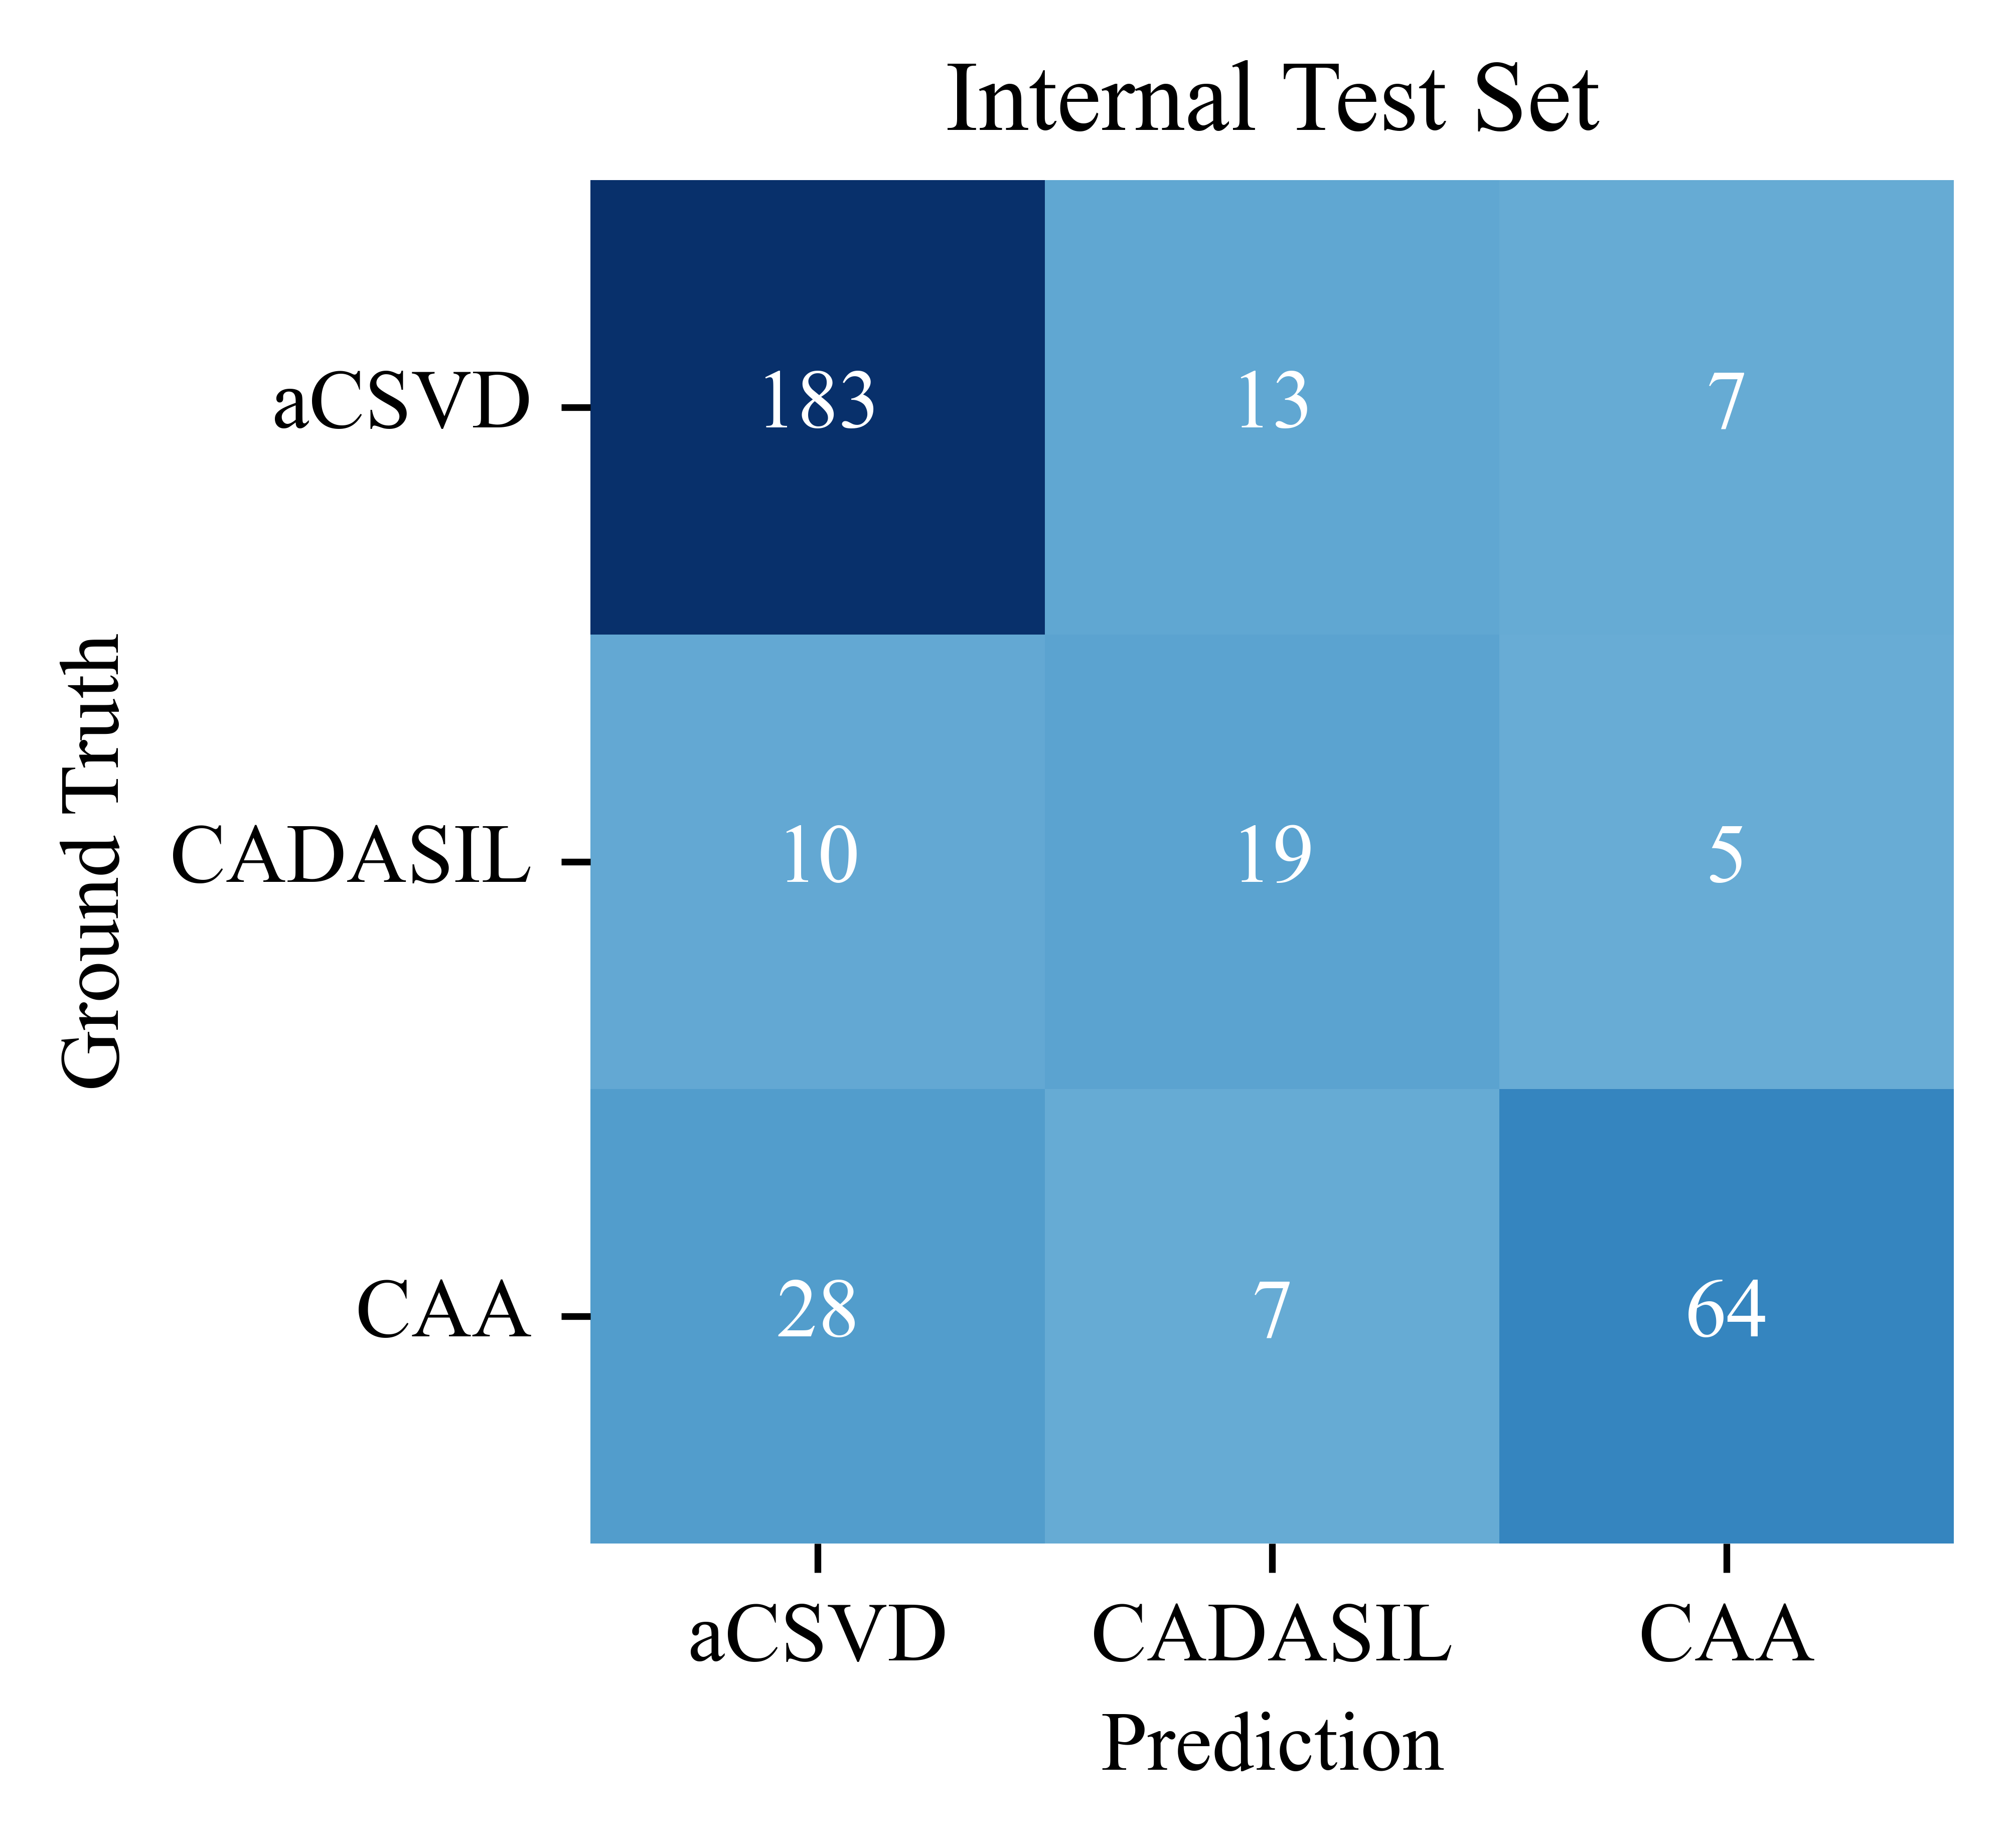

In [8]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
y_pred = np.argmax(proba,axis=1)
cm = confusion_matrix(label,y_pred).astype(int)
fig = plt.figure(dpi=params['dpi'],figsize=(3,3))
ax = sns.heatmap(cm,annot=True,fmt='d',center=True,cmap='Blues',cbar=False)
ax.set_aspect('equal','box')
ax.set_xticks(ticks=[0.5,1.5,2.5],labels=['aCSVD','CADASIL','CAA'],rotation='horizontal')
ax.set_yticks(ticks=[0.5,1.5,2.5],labels=['aCSVD','CADASIL','CAA'],rotation='horizontal')
ax.set_xlabel('Prediction')
ax.set_ylabel('Ground Truth')
ax.set_title('Internal Test Set')
plt.savefig(params['filepath_save_KFold_IntTestSetCat_CM'], dpi=params['dpi'], bbox_inches='tight')
plt.show()

### AUC及其95%CI

In [9]:
y_true = np.array(label,dtype=int)
y_prob = proba

AI_IntTestSetCat_AUC_df = AUC_CI_score(y_true=y_true, y_prob=y_prob, ci=95)
AI_IntTestSetCat_AUC_df.rename(index=dict( (cls_index,cls_name) for cls_name, cls_index in list(params['clses_name'].items())[:3] ), inplace=True)
    
display(AI_IntTestSetCat_AUC_df.T)   

aCSVD                      CADASIL  \
AUC  0.868, 95%CI: 0.846 ~ 0.890  0.836, 95%CI: 0.789 ~ 0.883   

                             CAA                        micro  \
AUC  0.862, 95%CI: 0.835 ~ 0.889  0.883, 95%CI: 0.868 ~ 0.899   

                           macro                     weighted  
AUC  0.855, 95%CI: 0.831 ~ 0.879  0.863, 95%CI: 0.841 ~ 0.884

### classification_report

In [10]:
y_true = np.array(label,dtype=int)
y_pred = np.argmax(proba,1)
AI_IntTestSetCat_report_CI_df = classification_CI_report(y_true=y_true, y_pred=y_pred, ci=95)
display( AI_IntTestSetCat_report_CI_df )

ACSVD                      CADASIL  \
precision  0.829, 95%CI: 0.817 ~ 0.841  0.488, 95%CI: 0.442 ~ 0.533   
recall     0.902, 95%CI: 0.890 ~ 0.914  0.557, 95%CI: 0.502 ~ 0.612   
f1-score   0.864, 95%CI: 0.854 ~ 0.873  0.520, 95%CI: 0.475 ~ 0.564   

                                   CAA                     accuracy  \
precision  0.843, 95%CI: 0.820 ~ 0.867  0.793, 95%CI: 0.779 ~ 0.806   
recall     0.649, 95%CI: 0.617 ~ 0.681  0.793, 95%CI: 0.779 ~ 0.806   
f1-score   0.733, 95%CI: 0.710 ~ 0.757  0.793, 95%CI: 0.779 ~ 0.806   

                             macro avg                 weighted avg  
precision  0.720, 95%CI: 0.701 ~ 0.739  0.799, 95%CI: 0.786 ~ 0.811  
recall     0.703, 95%CI: 0.682 ~ 0.724  0.793, 95%CI: 0.779 ~ 0.806  
f1-score   0.706, 95%CI: 0.686 ~ 0.725  0.791, 95%CI: 0.777 ~ 0.804

In [11]:

# # precision(labels=y_true, predictions=y_pred, num_classes=3, pos_indices=[0,1,2], average='macro')
# from sklearn import metrics
# average = 'micro'
# print( "accuracy:", metrics.accuracy_score(y_true, y_pred) )
# print( "{} precision:".format(average),metrics.precision_score(y_true, y_pred, average=average) )
# print( "{} recall:".format(average),metrics.recall_score(y_true, y_pred, average=average) )
# print( "{} f1_score:".format(average),metrics.f1_score(y_true, y_pred, average=average) )

# metrics.roc_auc_score(y_true=y_true, y_score=proba, average='weighted', multi_class='ovo')

## CV内部测试集独立评估

### 内部测试集的AUC及其95%CI

In [12]:
AI_IntTestSet_AUC_df = pd.DataFrame( 
    columns=['fold{:d}_AUC'.format(k) for k in range(10)], 
    index= list(params['clses_name'].keys())[:3]+['micro','macro','weighted'],
)
for k in range(10):
    y_true = np.array(label_cv['fold_{}'.format(k)]) # numpy array
    y_prob = proba_cv['fold_{}'.format(k)]# numpy array

    AUC_CI_score_df = AUC_CI_score(y_true=y_true, y_prob=y_prob, ci=95)
    AUC_CI_score_df.rename(index=dict( (cls_index,cls_name) for cls_name, cls_index in list(params['clses_name'].items())[:3] ), inplace=True)
    AI_IntTestSet_AUC_df.loc[:,'fold{:d}_AUC'.format(k)] = AUC_CI_score_df.values
        
# 将串联(平均)的AUC也拼接到最右侧
AI_IntTestSet_AUC_df['10fold_average_AUC'] = AI_IntTestSetCat_AUC_df
display(AI_IntTestSet_AUC_df.T)


aCSVD                      CADASIL  \
fold0_AUC           0.913, 95%CI: 0.889 ~ 0.936  1.000, 95%CI: 1.000 ~ 1.000   
fold1_AUC           0.822, 95%CI: 0.796 ~ 0.849  0.740, 95%CI: 0.668 ~ 0.812   
fold2_AUC           0.857, 95%CI: 0.830 ~ 0.883  0.889, 95%CI: 0.858 ~ 0.920   
fold3_AUC           0.889, 95%CI: 0.869 ~ 0.910  0.817, 95%CI: 0.769 ~ 0.864   
fold4_AUC           0.950, 95%CI: 0.940 ~ 0.961  0.951, 95%CI: 0.938 ~ 0.964   
fold5_AUC           0.882, 95%CI: 0.862 ~ 0.902  0.600, 95%CI: 0.529 ~ 0.671   
fold6_AUC           0.876, 95%CI: 0.852 ~ 0.901  1.000, 95%CI: 1.000 ~ 1.000   
fold7_AUC           0.931, 95%CI: 0.916 ~ 0.947  0.955, 95%CI: 0.942 ~ 0.969   
fold8_AUC           0.911, 95%CI: 0.892 ~ 0.931  0.910, 95%CI: 0.887 ~ 0.934   
fold9_AUC           0.843, 95%CI: 0.818 ~ 0.868  0.628, 95%CI: 0.541 ~ 0.716   
10fold_average_AUC  0.868, 95%CI: 0.846 ~ 0.890  0.836, 95%CI: 0.789 ~ 0.883   

                                            CAA                        micro  \
fold0_AUC           0.924, 95%CI: 0.909 ~ 0.938  0.924, 95%CI: 0.912 ~ 0.936   
fold1_AUC           0.837, 95%CI: 0.810 ~ 0.864  0.857, 95%CI: 0.841 ~ 0.874   
fold2_AUC           0.814, 95%CI: 0.782 ~ 0.845  0.859, 95%CI: 0.843 ~ 0.875   
fold3_AUC           0.868, 95%CI: 0.847 ~ 0.888  0.877, 95%CI: 0.863 ~ 0.892   
fold4_AUC           0.929, 95%CI: 0.913 ~ 0.945  0.891, 95%CI: 0.875 ~ 0.906   
fold5_AUC           0.928, 95%CI: 0.909 ~ 0.947  0.900, 95%CI: 0.889 ~ 0.912   
fold6_AUC           0.879, 95%CI: 0.855 ~ 0.903  0.897, 95%CI: 0.882 ~ 0.912   
fold7_AUC           0.921, 95%CI: 0.901 ~ 0.941  0.897, 95%CI: 0.881 ~ 0.914   
fold8_AUC           0.909, 95%CI: 0.886 ~ 0.931  0.917, 95%CI: 0.902 ~ 0.931   
fold9_AUC           0.924, 95%CI: 0.907 ~ 0.941  0.866, 95%CI: 0.849 ~ 0.883   
10fold_average_AUC  0.862, 95%CI: 0.835 ~ 0.889  0.883, 95%CI: 0.868 ~ 0.899   

                                          macro                     weighted  
fold0_AUC           0.946, 95%CI: 0.935 ~ 0.956  0.924, 95%CI: 0.907 ~ 0.940  
fold1_AUC           0.800, 95%CI: 0.770 ~ 0.830  0.819, 95%CI: 0.795 ~ 0.844  
fold2_AUC           0.853, 95%CI: 0.830 ~ 0.877  0.849, 95%CI: 0.824 ~ 0.874  
fold3_AUC           0.858, 95%CI: 0.835 ~ 0.880  0.874, 95%CI: 0.855 ~ 0.894  
fold4_AUC           0.944, 95%CI: 0.935 ~ 0.952  0.944, 95%CI: 0.934 ~ 0.954  
fold5_AUC           0.803, 95%CI: 0.774 ~ 0.832  0.862, 95%CI: 0.843 ~ 0.882  
fold6_AUC           0.918, 95%CI: 0.904 ~ 0.933  0.888, 95%CI: 0.868 ~ 0.908  
fold7_AUC           0.936, 95%CI: 0.923 ~ 0.949  0.930, 95%CI: 0.915 ~ 0.945  
fold8_AUC           0.910, 95%CI: 0.895 ~ 0.925  0.910, 95%CI: 0.892 ~ 0.929  
fold9_AUC           0.799, 95%CI: 0.762 ~ 0.835  0.848, 95%CI: 0.825 ~ 0.872  
10fold_average_AUC  0.855, 95%CI: 0.831 ~ 0.879  0.863, 95%CI: 0.841 ~ 0.884

### 内部测试集的classification report及其95%CI

In [13]:
KFold_IntTestSet_report_dict = dict([])
for k in range(10):
    y_true = np.array(label_cv['fold_{}'.format(k)]).astype(int) # numpy array
    y_prob = proba_cv['fold_{}'.format(k)]# numpy array
#     y_prob[:,1] += 0.1
    y_pred = np.argmax(y_prob,1)
    report_CI_df = classification_CI_report(y_true=y_true, y_pred=y_pred, ci=95)
    KFold_IntTestSet_report_dict['fold{:d}'.format(k)] = report_CI_df

/opt/conda/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2098: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/opt/conda/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2099: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/opt/conda/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2098: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/opt/conda/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2099: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/opt/conda/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2098: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/opt/conda/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2099: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b 

### 保存各类指标数据到表格文件

In [14]:
with pd.ExcelWriter(params['filepath_save_KFold_IntTestSet_Metrics']) as xlsx:
    AI_IntTestSet_AUC_df.to_excel(xlsx, sheet_name="单模型的AUC")
    for sheet_name, report_dict in KFold_IntTestSet_report_dict.items():
        report_dict.to_excel(xlsx, sheet_name=sheet_name)
    AI_IntTestSetCat_report_CI_df.to_excel(xlsx, "10个单模型的平均指标")

## 外部测试集

### 前向推理

In [15]:
from models.model_toad import *
from datasets.WRZ_DataSet_withMask import *
from utils.core_utils_mix import *
from utils.file_utils import save_pkl, load_pkl


if __name__ == "__main__":
           
    # 临床信息(clin_df的index和patient_ID对应)
    clin_df = get_clinical_df(params["clinical_filepath"])
    # 接下来仅纳入有临床信息的病例（部分病例不输入本研究的3个类别，剔除了，临床信息excel表中也删除了相应的行，所以以临床信息表为准）
    # ACSVD改为aCSVD
    clin_df.index = pd.Series(clin_df.index).apply( lambda x: x.replace("ACSVD","aCSVD") )
    clin_df.loc[ clin_df["cls"]=='ACSVD', "cls"] = "aCSVD"
    
    
    # ##############################################################
    # 获取整个数据集的文件全名列表
    filepath_df = pd.DataFrame(columns=['filepath'])
    for pat in params['pats']:
        filepaths = glob(pat)
        patient_IDs = ['_'.join(filepath.split(os.path.sep)[-3:]).replace('_before_ROI','').replace('_SWS.nii.gz','').replace('_processed','') for filepath in filepaths]
        for patient_ID,filepath in zip(patient_IDs,filepaths):
            filepath_df.loc[patient_ID,'filepath'] = filepath
    
    filepath_df = filepath_df.loc[clin_df.index,:]# 仅纳入有临床信息的病例
    patient_IDs = list(filepath_df.index)# 为dataset做准备
    filepath_list = filepath_df.loc[:,'filepath']
    # 添加(预测)mask文件路径名
    filepath_list = [(filepath,filepath.replace('.nii.gz','_ROI.nii.gz')) for filepath in filepath_list]
    
    # 临床信息(clin_df的index和patient_ID对应)
    clin_list = []
    for patient_ID in patient_IDs:
        gender = clin_df.loc[patient_ID,'Gender']
        age = clin_df.loc[patient_ID,'Age']
        clin_list += [{'gender':gender,'age':age}]
        
    # 这是疾病的3分类标签
    label_list = []
    for patient_ID in patient_IDs:
        for cls_name, cls in params['clses_name'].items():
            if cls_name in patient_ID:
                label_list += [{'class':cls}]
                break
    # ############################################################## 
    
    test_filepath_list = filepath_list
    test_label_list = label_list 
    test_clin_list = clin_list
    
    test_dataset = WRZ_Single_withMask_Dataset(
            data_dir=None,# '/raid/huaqing/tyler/WRZ/data/data_V2_nii_gz', 
            filepath_list=test_filepath_list, 
            label_list=test_label_list,
            clin_list=test_clin_list,
            clses_name=params['clses_name'],
            fixedFilepaths=None,#fixedFilepath_list,#None,#fixedFilepath_list,
            transform=transforms.Compose([
#                 SITKCropOuterFrame( 5 ),
#                 SITKNormalize(),
                SITKResample( (1.0,1.0,3.5) ),# (1.0,1.0,2.5) #(0.5,0.5,2.5)#SITKResample( (0.5,0.5,4.0) ),
                SITKAdaptiveHistEqual(),
                SITKtoNumpy(),
                ToTensor(),
                ScaleVoxelValue(quantile=0.995),
                AddChannelDim(),
                ConcatChannelDim(),
            ])
    )

    test_loader = get_split_loader(test_dataset)
    print('Number of samples: {}'.format(len(test_filepath_list)))
#     display(test_filepath_list)

Number of samples: 28


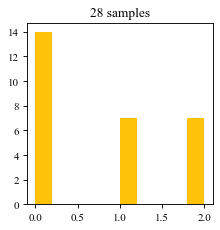

In [16]:
if __name__ == '__main__':
    plt.figure(dpi=80,figsize=(3,3))
    plt.hist([item['class'] for item in test_label_list],color=params['color_list'][0])
    plt.title('{} samples'.format(len(test_loader.dataset._label_list)))
    plt.show()

In [17]:
# cls_labels, cls_probs = predict(model,test_dataset,mix=True)

# k折交叉验证的结果整合起来
for k in range(10):
    model_filepath = params['trained_model_filepath'].format(k)
    # 加载模型
    model = torch.load(model_filepath)
    from torch.nn.parallel.data_parallel import DataParallel
    if isinstance(model,DataParallel):
        model = net.module
    for child in model.children():
        for param in child.parameters():
            param.requires_grad = True
    model.to(device)
    model.eval()
    label_k, prob_k = predict(model, test_loader, mix=params['mix'], device=device)
    
    if k==0:
        label = label_k[:,np.newaxis]
        prob = prob_k[:,np.newaxis,:]
    else:
        label = np.concatenate((label,label_k[:,np.newaxis]), axis=1)
        prob = np.concatenate((prob, prob_k[:,np.newaxis,:]), axis=1)
cls_labels, cls_probs = label, prob

28it [00:06,  4.12it/s]
28it [00:06,  4.32it/s]
28it [00:06,  4.02it/s]
28it [00:06,  4.42it/s]
28it [00:07,  3.84it/s]
28it [00:06,  4.29it/s]
28it [00:06,  4.29it/s]
28it [00:06,  4.26it/s]
28it [00:06,  4.13it/s]
28it [00:06,  4.07it/s]


### 外部测试集的AUC及其95%CI

In [18]:

# ROAUC 
AI_ExtTestSet_AUC_df = pd.DataFrame( 
    columns=['fold{:d}_AUC'.format(k) for k in range(10)], 
    index= list(params['clses_name'].keys())[:3]+['micro','macro','weighted'],
)

# 10个单模型分别的的AUC
for k in range(10):
    y_true = cls_labels[:,k]# numpy array
    y_prob = cls_probs[:,k,:]# numpy array

    AUC_CI_score_df = AUC_CI_score(y_true=y_true, y_prob=y_prob, ci=95)
    AUC_CI_score_df.rename(index=dict( (cls_index,cls_name) for cls_name, cls_index in list(params['clses_name'].items())[:3] ), inplace=True)
    AI_ExtTestSet_AUC_df.loc[:,'fold{:d}_AUC'.format(k)] = AUC_CI_score_df.values

# 10个单模型串联(平均)后的AUC
y_true = cls_labels.reshape(-1,)
y_prob = cls_probs.reshape(-1,3)
y_pred = np.argmax(y_prob,1)
AUC_CI_score_df = AUC_CI_score(y_true=y_true, y_prob=y_prob, ci=95)
AI_ExtTestSet_AUC_df['10 folds average'] = AUC_CI_score_df

display(AI_ExtTestSet_AUC_df.T)

aCSVD                      CADASIL  \
fold0_AUC         0.969, 95%CI: 0.960 ~ 0.978  0.745, 95%CI: 0.708 ~ 0.782   
fold1_AUC         0.959, 95%CI: 0.949 ~ 0.969  0.755, 95%CI: 0.715 ~ 0.795   
fold2_AUC         0.960, 95%CI: 0.950 ~ 0.970  0.755, 95%CI: 0.716 ~ 0.793   
fold3_AUC         0.959, 95%CI: 0.948 ~ 0.970  0.781, 95%CI: 0.743 ~ 0.818   
fold4_AUC         0.964, 95%CI: 0.954 ~ 0.974  0.850, 95%CI: 0.830 ~ 0.869   
fold5_AUC         0.964, 95%CI: 0.952 ~ 0.975  0.843, 95%CI: 0.819 ~ 0.867   
fold6_AUC         0.968, 95%CI: 0.958 ~ 0.978  0.793, 95%CI: 0.752 ~ 0.834   
fold7_AUC         0.964, 95%CI: 0.954 ~ 0.973  0.802, 95%CI: 0.762 ~ 0.842   
fold8_AUC         0.964, 95%CI: 0.952 ~ 0.975  0.829, 95%CI: 0.808 ~ 0.850   
fold9_AUC         0.960, 95%CI: 0.948 ~ 0.971  0.802, 95%CI: 0.768 ~ 0.836   
10 folds average                          NaN                          NaN   

                                          CAA                        micro  \
fold0_AUC         0.939, 95%CI: 0.926 ~ 0.952  0.849, 95%CI: 0.834 ~ 0.864   
fold1_AUC         0.946, 95%CI: 0.933 ~ 0.958  0.870, 95%CI: 0.854 ~ 0.886   
fold2_AUC         0.945, 95%CI: 0.932 ~ 0.958  0.860, 95%CI: 0.842 ~ 0.878   
fold3_AUC         0.939, 95%CI: 0.925 ~ 0.952  0.899, 95%CI: 0.885 ~ 0.913   
fold4_AUC         0.945, 95%CI: 0.934 ~ 0.955  0.909, 95%CI: 0.896 ~ 0.922   
fold5_AUC         0.939, 95%CI: 0.925 ~ 0.954  0.886, 95%CI: 0.872 ~ 0.900   
fold6_AUC         0.945, 95%CI: 0.932 ~ 0.958  0.870, 95%CI: 0.854 ~ 0.887   
fold7_AUC         0.946, 95%CI: 0.932 ~ 0.960  0.847, 95%CI: 0.828 ~ 0.865   
fold8_AUC         0.938, 95%CI: 0.925 ~ 0.951  0.916, 95%CI: 0.906 ~ 0.925   
fold9_AUC         0.945, 95%CI: 0.934 ~ 0.956  0.897, 95%CI: 0.882 ~ 0.913   
10 folds average                          NaN  0.877, 95%CI: 0.861 ~ 0.894   

                                        macro                     weighted  
fold0_AUC         0.884, 95%CI: 0.868 ~ 0.901  0.906, 95%CI: 0.892 ~ 0.919  
fold1_AUC         0.887, 95%CI: 0.869 ~ 0.904  0.905, 95%CI: 0.891 ~ 0.919  
fold2_AUC         0.887, 95%CI: 0.869 ~ 0.904  0.905, 95%CI: 0.891 ~ 0.919  
fold3_AUC         0.893, 95%CI: 0.876 ~ 0.910  0.909, 95%CI: 0.895 ~ 0.923  
fold4_AUC         0.919, 95%CI: 0.909 ~ 0.930  0.931, 95%CI: 0.921 ~ 0.940  
fold5_AUC         0.915, 95%CI: 0.902 ~ 0.929  0.927, 95%CI: 0.915 ~ 0.940  
fold6_AUC         0.902, 95%CI: 0.884 ~ 0.920  0.919, 95%CI: 0.904 ~ 0.933  
fold7_AUC         0.904, 95%CI: 0.886 ~ 0.922  0.919, 95%CI: 0.904 ~ 0.933  
fold8_AUC         0.910, 95%CI: 0.898 ~ 0.922  0.923, 95%CI: 0.912 ~ 0.935  
fold9_AUC         0.902, 95%CI: 0.886 ~ 0.918  0.916, 95%CI: 0.903 ~ 0.930  
10 folds average  0.881, 95%CI: 0.864 ~ 0.899  0.899, 95%CI: 0.885 ~ 0.914

### 外部测试集的ROC曲线

{0: 0.9538, 1: 0.7604, 2: 0.929, 'micro': 0.8776, 'macro': 0.8855, 'weighted': 0.9031}


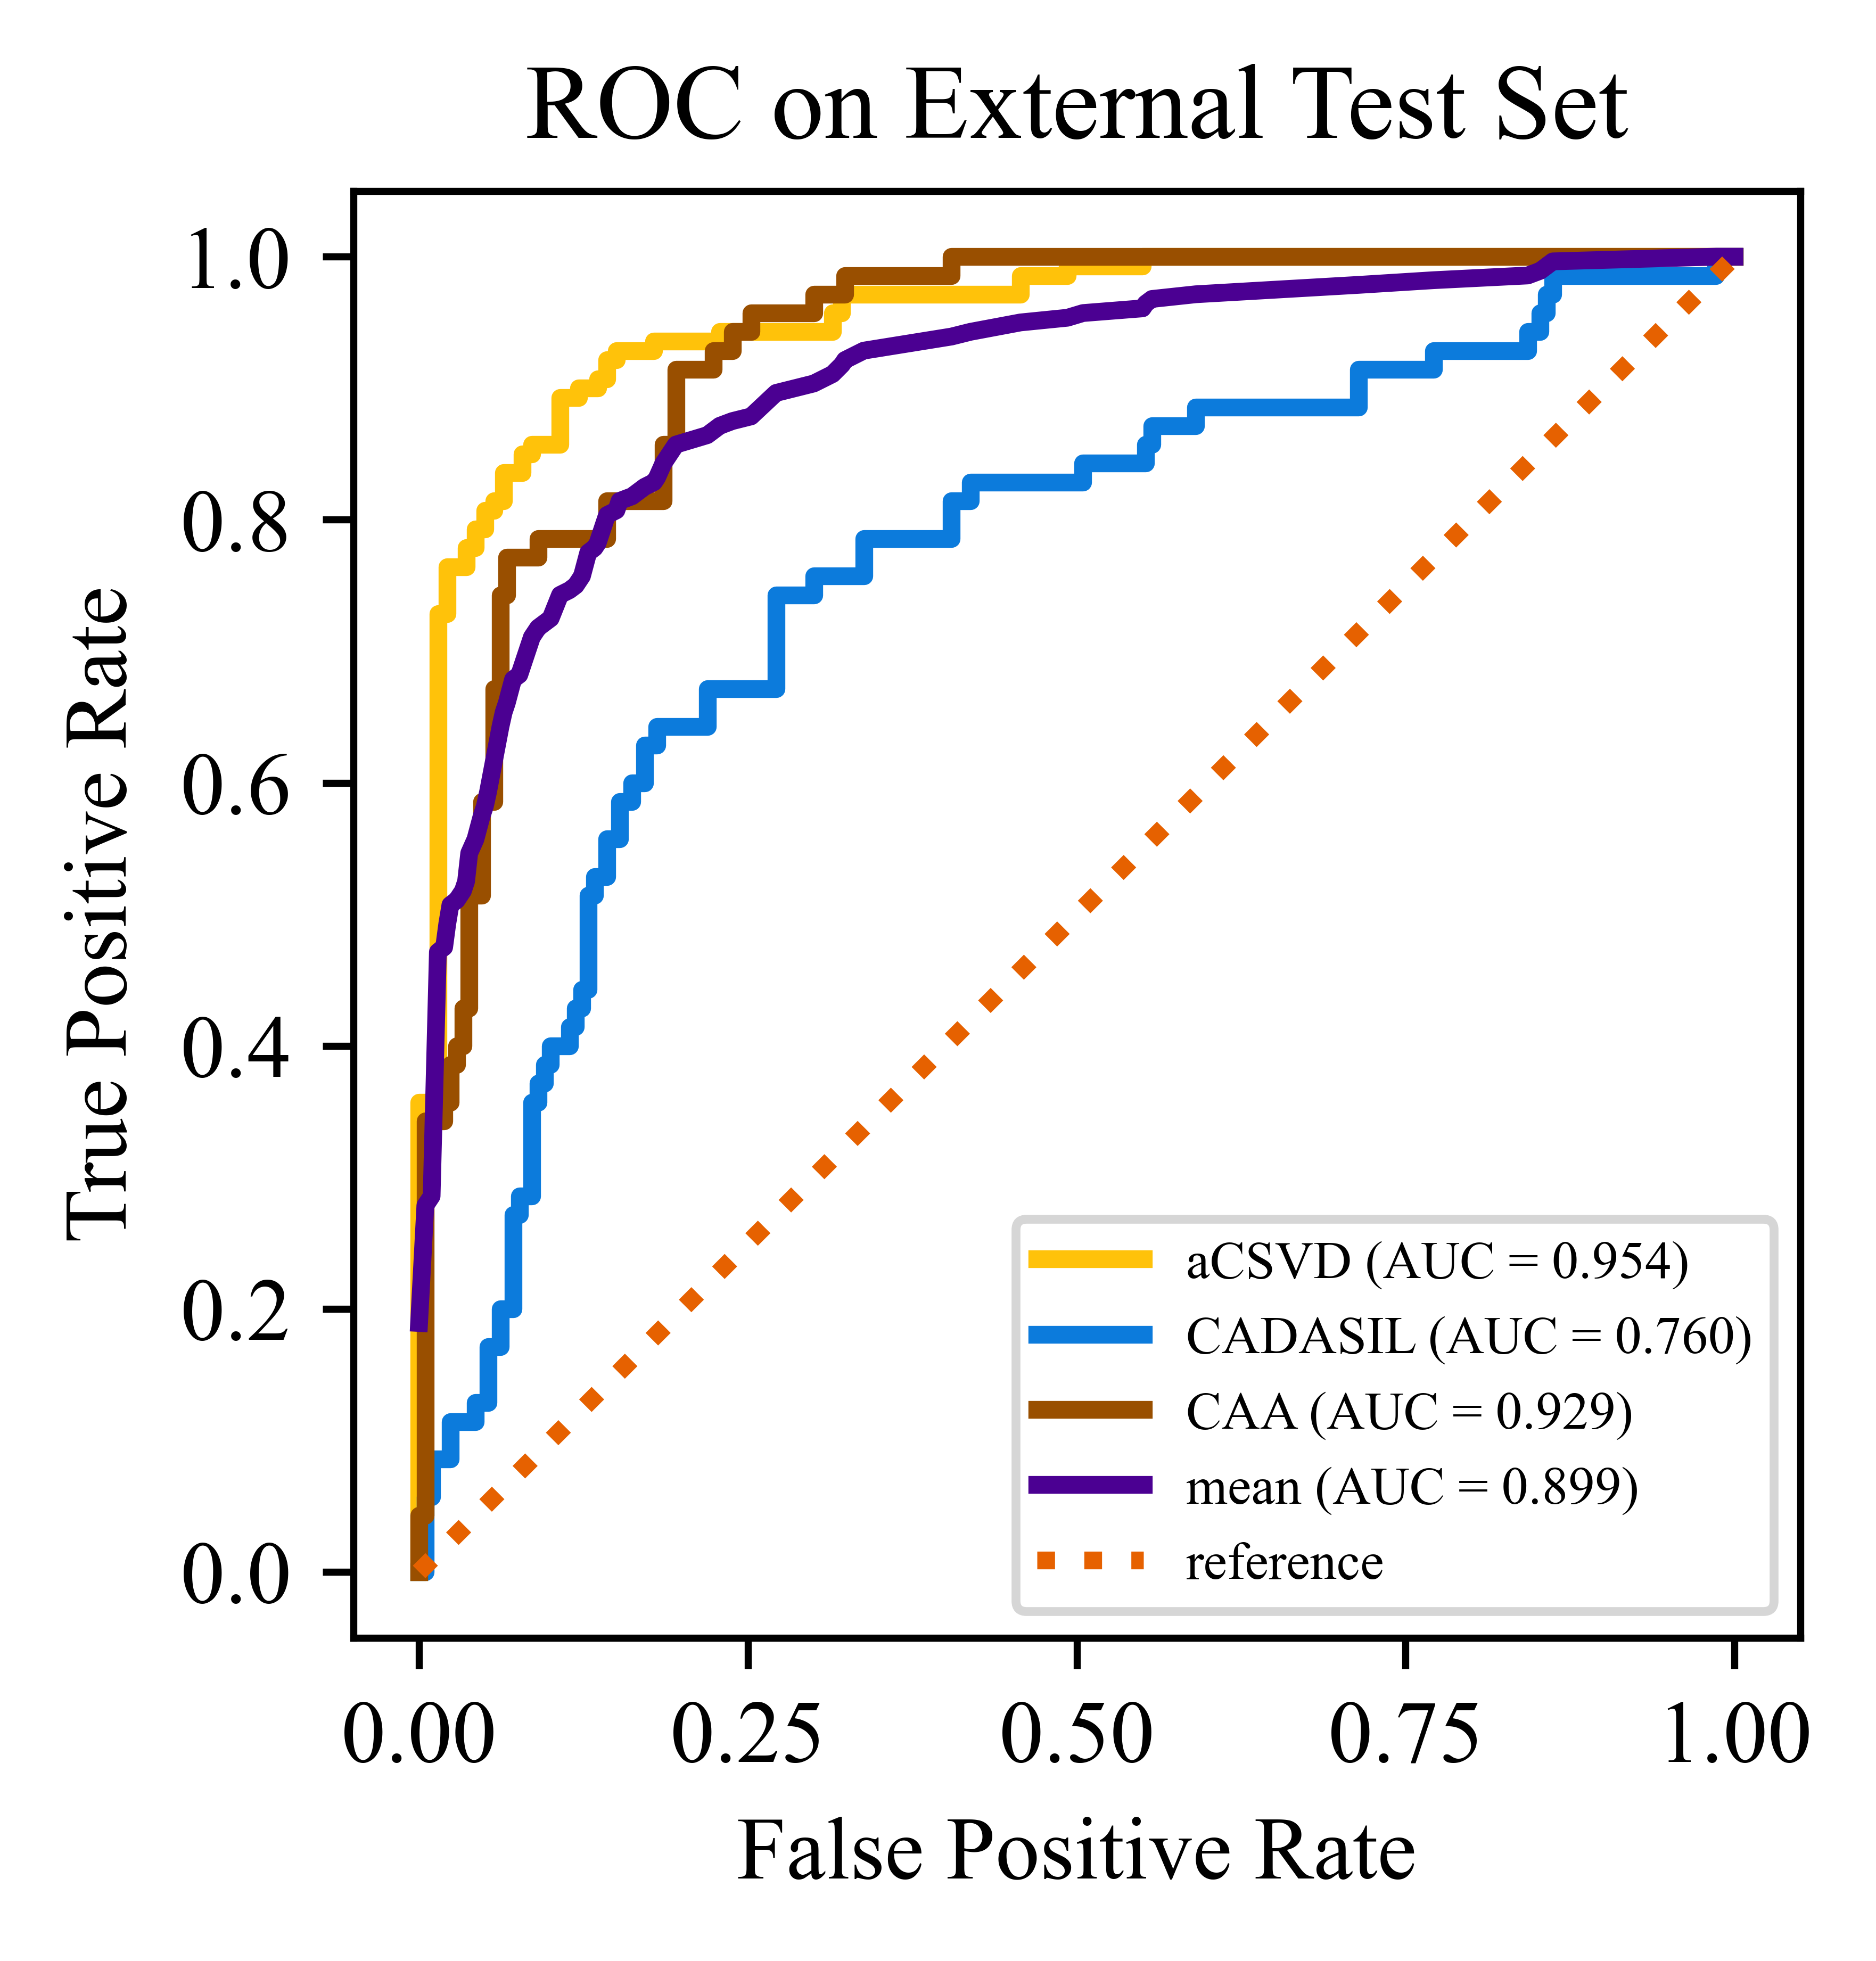

In [19]:
y_true = enc.fit_transform(cls_labels.reshape(-1,1))
y_true = y_true.toarray()
fpr, tpr, roc_auc = get_roc(y_true=y_true, y_score=y_prob, n_classes=3)
print(roc_auc)

########### 画图：###########
import matplotlib.pyplot as plt
# 新建一块画布
fig,ax = plt.subplots(1,1,dpi=params['dpi'],figsize=(3,3))
# 画测试集的roc曲线
tmp_dict = params['clses_name']
tmp_dict.update({'mean':'weighted'})
ic = 0# 记录颜色序号
############################################################################################################
# 由于boostrap方法统计95%CI，存在一定随机性，倒是每次计算出来的数值最后一1~2位小数不固定，所以在此手动定义数值大小，用于绘图
AUC_SCORE = {"aCSVD":0.954, "CADASIL":0.760, "CAA":0.929, "mean":0.899}
############################################################################################################
ic = 0# 记录颜色序号
for label_name, key in tmp_dict.items():
    if key in ['micro','macro','weighted','mean']:
        auc_score = float(AI_ExtTestSet_AUC_df.loc[key,'10 folds average'].split(',')[0])
        plt.plot(fpr[key], tpr[key],
#                  linestyle='--',
                 lw=2, 
                 label='{} (AUC = {:.3f})'.format(label_name,auc_score),
                 color=params['color_list'][ic],
                )
        ic += 1
    else:
        plt.plot(fpr[key], tpr[key],
                 lw=2, 
                 label='{} (AUC = {:.3f})'.format(label_name, roc_auc[key]),
                 color=params['color_list'][ic],
                )
        ic += 1
    
    
# 画参考线
plt.plot([0, 1], [0, 1], lw=2, linestyle=':',label='reference', color=params['color_list'][ic])
ic += 1
plt.xlabel('False Positive Rate')# x坐标轴名字
plt.ylabel('True Positive Rate')# y坐标轴名字
plt.title('ROC on External Test Set')# 标题
plt.legend(fontsize=6, loc="lower right")# 图例

ax.set_xlim([-0.05,1.05])
ax.set_ylim([-0.05,1.05])
ax.set_aspect('equal','box')

plt.savefig( fname=params['filepath_save_KFold_ExtTestSet_ROC'], dpi=params['dpi'], bbox_inches='tight')
plt.show() 

### 外部测试集的classification report及其95%CI

In [20]:

import itertools as it
from sklearn.metrics import classification_report

KFold_ExtTestSet_report_dict = dict([])
# 10个单模型分别的的classification_report
for k in range(10):
    y_true = cls_labels[:,k] # numpy array
    y_prob = cls_probs[:,k,:]# numpy array
    y_pred = np.argmax(y_prob,1)
    report_CI_df = classification_CI_report(y_true=y_true, y_pred=y_pred, ci=95)
    display(report_CI_df)
    KFold_ExtTestSet_report_dict['fold{:d}'.format(k)] = report_CI_df
    
# 10个单模型串联(平均)后的classification_report
y_true = cls_labels.reshape(-1,)
y_prob = cls_probs.reshape(-1,3)
y_pred = np.argmax(y_prob,1)
report_CI_df = classification_CI_report(y_true=y_true, y_pred=y_pred, ci=95)
KFold_ExtTestSet_report_dict['10 folds average'] = report_CI_df

/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classificat

/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classificat

/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classificat

/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classificat

ACSVD                  CADASIL  \
precision  0.873, 95%CI: 0.827 ~ 0.919  0.000, 95%CI: nan ~ nan   
recall     0.931, 95%CI: 0.891 ~ 0.971  0.000, 95%CI: nan ~ nan   
f1-score   0.901, 95%CI: 0.866 ~ 0.935  0.000, 95%CI: nan ~ nan   

                                   CAA                     accuracy  \
precision  0.537, 95%CI: 0.500 ~ 0.574  0.716, 95%CI: 0.695 ~ 0.736   
recall         1.000, 95%CI: nan ~ nan  0.716, 95%CI: 0.695 ~ 0.736   
f1-score   0.698, 95%CI: 0.667 ~ 0.729  0.716, 95%CI: 0.695 ~ 0.736   

                             macro avg                 weighted avg  
precision  0.470, 95%CI: 0.459 ~ 0.481  0.571, 95%CI: 0.553 ~ 0.589  
recall     0.644, 95%CI: 0.630 ~ 0.657  0.716, 95%CI: 0.695 ~ 0.736  
f1-score   0.533, 95%CI: 0.519 ~ 0.547  0.625, 95%CI: 0.608 ~ 0.642

/opt/conda/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2098: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/opt/conda/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2099: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


ACSVD                      CADASIL  \
precision  0.858, 95%CI: 0.810 ~ 0.906      1.000, 95%CI: nan ~ nan   
recall     0.855, 95%CI: 0.797 ~ 0.914  0.138, 95%CI: 0.047 ~ 0.229   
f1-score   0.856, 95%CI: 0.815 ~ 0.897  0.240, 95%CI: 0.098 ~ 0.382   

                                   CAA                     accuracy  \
precision  0.537, 95%CI: 0.486 ~ 0.587  0.712, 95%CI: 0.674 ~ 0.750   
recall         1.000, 95%CI: nan ~ nan  0.712, 95%CI: 0.674 ~ 0.750   
f1-score   0.698, 95%CI: 0.655 ~ 0.741  0.712, 95%CI: 0.674 ~ 0.750   

                             macro avg                 weighted avg  
precision  0.798, 95%CI: 0.780 ~ 0.816  0.813, 95%CI: 0.791 ~ 0.835  
recall     0.664, 95%CI: 0.628 ~ 0.701  0.712, 95%CI: 0.674 ~ 0.750  
f1-score   0.598, 95%CI: 0.539 ~ 0.657  0.663, 95%CI: 0.613 ~ 0.712

/opt/conda/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2098: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/opt/conda/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2099: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


ACSVD                      CADASIL  \
precision      1.000, 95%CI: nan ~ nan  0.500, 95%CI: 0.393 ~ 0.608   
recall     0.786, 95%CI: 0.721 ~ 0.850  0.425, 95%CI: 0.305 ~ 0.544   
f1-score   0.880, 95%CI: 0.839 ~ 0.920  0.458, 95%CI: 0.352 ~ 0.564   

                                   CAA                     accuracy  \
precision  0.544, 95%CI: 0.484 ~ 0.604  0.713, 95%CI: 0.665 ~ 0.762   
recall     0.857, 95%CI: 0.774 ~ 0.941  0.713, 95%CI: 0.665 ~ 0.762   
f1-score   0.665, 95%CI: 0.604 ~ 0.726  0.713, 95%CI: 0.665 ~ 0.762   

                             macro avg                 weighted avg  
precision  0.681, 95%CI: 0.631 ~ 0.731  0.761, 95%CI: 0.724 ~ 0.799  
recall     0.689, 95%CI: 0.635 ~ 0.743  0.713, 95%CI: 0.665 ~ 0.762  
f1-score   0.668, 95%CI: 0.613 ~ 0.722  0.721, 95%CI: 0.674 ~ 0.767

ACSVD                      CADASIL  \
precision  0.873, 95%CI: 0.832 ~ 0.914  0.508, 95%CI: 0.381 ~ 0.635   
recall     0.928, 95%CI: 0.888 ~ 0.968  0.291, 95%CI: 0.182 ~ 0.399   
f1-score   0.900, 95%CI: 0.871 ~ 0.928  0.368, 95%CI: 0.255 ~ 0.481   

                                   CAA                     accuracy  \
precision  0.664, 95%CI: 0.598 ~ 0.731  0.752, 95%CI: 0.716 ~ 0.789   
recall     0.861, 95%CI: 0.776 ~ 0.946  0.752, 95%CI: 0.716 ~ 0.789   
f1-score   0.749, 95%CI: 0.689 ~ 0.809  0.752, 95%CI: 0.716 ~ 0.789   

                             macro avg                 weighted avg  
precision  0.682, 95%CI: 0.623 ~ 0.740  0.729, 95%CI: 0.682 ~ 0.776  
recall     0.693, 95%CI: 0.649 ~ 0.738  0.752, 95%CI: 0.716 ~ 0.789  
f1-score   0.672, 95%CI: 0.620 ~ 0.724  0.729, 95%CI: 0.688 ~ 0.771

ACSVD                      CADASIL  \
precision  0.869, 95%CI: 0.829 ~ 0.909  0.501, 95%CI: 0.414 ~ 0.589   
recall     0.929, 95%CI: 0.883 ~ 0.975  0.576, 95%CI: 0.466 ~ 0.686   
f1-score   0.898, 95%CI: 0.866 ~ 0.930  0.535, 95%CI: 0.446 ~ 0.625   

                                   CAA                     accuracy  \
precision  0.799, 95%CI: 0.704 ~ 0.894  0.750, 95%CI: 0.700 ~ 0.800   
recall     0.567, 95%CI: 0.455 ~ 0.679  0.750, 95%CI: 0.700 ~ 0.800   
f1-score   0.662, 95%CI: 0.567 ~ 0.756  0.750, 95%CI: 0.700 ~ 0.800   

                             macro avg                 weighted avg  
precision  0.723, 95%CI: 0.665 ~ 0.781  0.760, 95%CI: 0.711 ~ 0.809  
recall     0.691, 95%CI: 0.631 ~ 0.750  0.750, 95%CI: 0.700 ~ 0.800  
f1-score   0.698, 95%CI: 0.638 ~ 0.758  0.748, 95%CI: 0.698 ~ 0.798

ACSVD                      CADASIL  \
precision  0.865, 95%CI: 0.828 ~ 0.903  0.519, 95%CI: 0.307 ~ 0.730   
recall     0.930, 95%CI: 0.886 ~ 0.973  0.151, 95%CI: 0.066 ~ 0.235   
f1-score   0.896, 95%CI: 0.868 ~ 0.925  0.231, 95%CI: 0.116 ~ 0.347   

                                   CAA                     accuracy  \
precision  0.552, 95%CI: 0.498 ~ 0.606  0.717, 95%CI: 0.682 ~ 0.752   
recall     0.859, 95%CI: 0.772 ~ 0.946  0.717, 95%CI: 0.682 ~ 0.752   
f1-score   0.672, 95%CI: 0.615 ~ 0.728  0.717, 95%CI: 0.682 ~ 0.752   

                             macro avg                 weighted avg  
precision  0.645, 95%CI: 0.562 ~ 0.728  0.700, 95%CI: 0.635 ~ 0.765  
recall     0.647, 95%CI: 0.606 ~ 0.687  0.717, 95%CI: 0.682 ~ 0.752  
f1-score   0.600, 95%CI: 0.550 ~ 0.649  0.674, 95%CI: 0.634 ~ 0.714

/opt/conda/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2098: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/opt/conda/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2099: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


ACSVD                      CADASIL  \
precision      1.000, 95%CI: nan ~ nan  0.499, 95%CI: 0.383 ~ 0.614   
recall     0.715, 95%CI: 0.643 ~ 0.787  0.426, 95%CI: 0.299 ~ 0.552   
f1-score   0.833, 95%CI: 0.784 ~ 0.882  0.458, 95%CI: 0.343 ~ 0.573   

                                   CAA                     accuracy  \
precision  0.500, 95%CI: 0.442 ~ 0.557  0.678, 95%CI: 0.624 ~ 0.732   
recall     0.856, 95%CI: 0.773 ~ 0.939  0.678, 95%CI: 0.624 ~ 0.732   
f1-score   0.631, 95%CI: 0.570 ~ 0.691  0.678, 95%CI: 0.624 ~ 0.732   

                             macro avg                 weighted avg  
precision  0.666, 95%CI: 0.614 ~ 0.718  0.750, 95%CI: 0.711 ~ 0.788  
recall     0.665, 95%CI: 0.608 ~ 0.723  0.678, 95%CI: 0.624 ~ 0.732  
f1-score   0.641, 95%CI: 0.582 ~ 0.699  0.689, 95%CI: 0.637 ~ 0.740

/opt/conda/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2098: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/opt/conda/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2099: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


ACSVD                      CADASIL  \
precision      1.000, 95%CI: nan ~ nan  0.503, 95%CI: 0.398 ~ 0.609   
recall     0.713, 95%CI: 0.637 ~ 0.789  0.433, 95%CI: 0.321 ~ 0.546   
f1-score   0.832, 95%CI: 0.780 ~ 0.884  0.464, 95%CI: 0.367 ~ 0.562   

                                   CAA                     accuracy  \
precision  0.502, 95%CI: 0.450 ~ 0.554  0.679, 95%CI: 0.630 ~ 0.728   
recall     0.858, 95%CI: 0.785 ~ 0.930  0.679, 95%CI: 0.630 ~ 0.728   
f1-score   0.633, 95%CI: 0.583 ~ 0.683  0.679, 95%CI: 0.630 ~ 0.728   

                             macro avg                 weighted avg  
precision  0.669, 95%CI: 0.624 ~ 0.713  0.751, 95%CI: 0.718 ~ 0.785  
recall     0.668, 95%CI: 0.619 ~ 0.717  0.679, 95%CI: 0.630 ~ 0.728  
f1-score   0.643, 95%CI: 0.592 ~ 0.694  0.690, 95%CI: 0.643 ~ 0.737

ACSVD                      CADASIL  \
precision  0.813, 95%CI: 0.771 ~ 0.855  0.507, 95%CI: 0.398 ~ 0.617   
recall     0.933, 95%CI: 0.890 ~ 0.976  0.427, 95%CI: 0.316 ~ 0.538   
f1-score   0.869, 95%CI: 0.834 ~ 0.903  0.462, 95%CI: 0.363 ~ 0.561   

                                   CAA                     accuracy  \
precision  0.835, 95%CI: 0.760 ~ 0.911  0.752, 95%CI: 0.708 ~ 0.797   
recall     0.717, 95%CI: 0.605 ~ 0.829  0.752, 95%CI: 0.708 ~ 0.797   
f1-score   0.770, 95%CI: 0.692 ~ 0.849  0.752, 95%CI: 0.708 ~ 0.797   

                             macro avg                 weighted avg  
precision  0.719, 95%CI: 0.665 ~ 0.772  0.742, 95%CI: 0.696 ~ 0.788  
recall     0.692, 95%CI: 0.638 ~ 0.746  0.752, 95%CI: 0.708 ~ 0.797  
f1-score   0.700, 95%CI: 0.647 ~ 0.754  0.742, 95%CI: 0.697 ~ 0.788

ACSVD                      CADASIL  \
precision  0.923, 95%CI: 0.875 ~ 0.971  0.400, 95%CI: 0.269 ~ 0.532   
recall     0.858, 95%CI: 0.805 ~ 0.911  0.286, 95%CI: 0.184 ~ 0.388   
f1-score   0.889, 95%CI: 0.852 ~ 0.926  0.332, 95%CI: 0.224 ~ 0.441   

                                   CAA                     accuracy  \
precision  0.600, 95%CI: 0.538 ~ 0.662  0.714, 95%CI: 0.664 ~ 0.763   
recall     0.852, 95%CI: 0.759 ~ 0.946  0.714, 95%CI: 0.664 ~ 0.763   
f1-score   0.704, 95%CI: 0.639 ~ 0.769  0.714, 95%CI: 0.664 ~ 0.763   

                             macro avg                 weighted avg  
precision  0.641, 95%CI: 0.579 ~ 0.703  0.712, 95%CI: 0.660 ~ 0.763  
recall     0.665, 95%CI: 0.609 ~ 0.721  0.714, 95%CI: 0.664 ~ 0.763  
f1-score   0.642, 95%CI: 0.585 ~ 0.699  0.704, 95%CI: 0.656 ~ 0.751

### 混淆矩阵

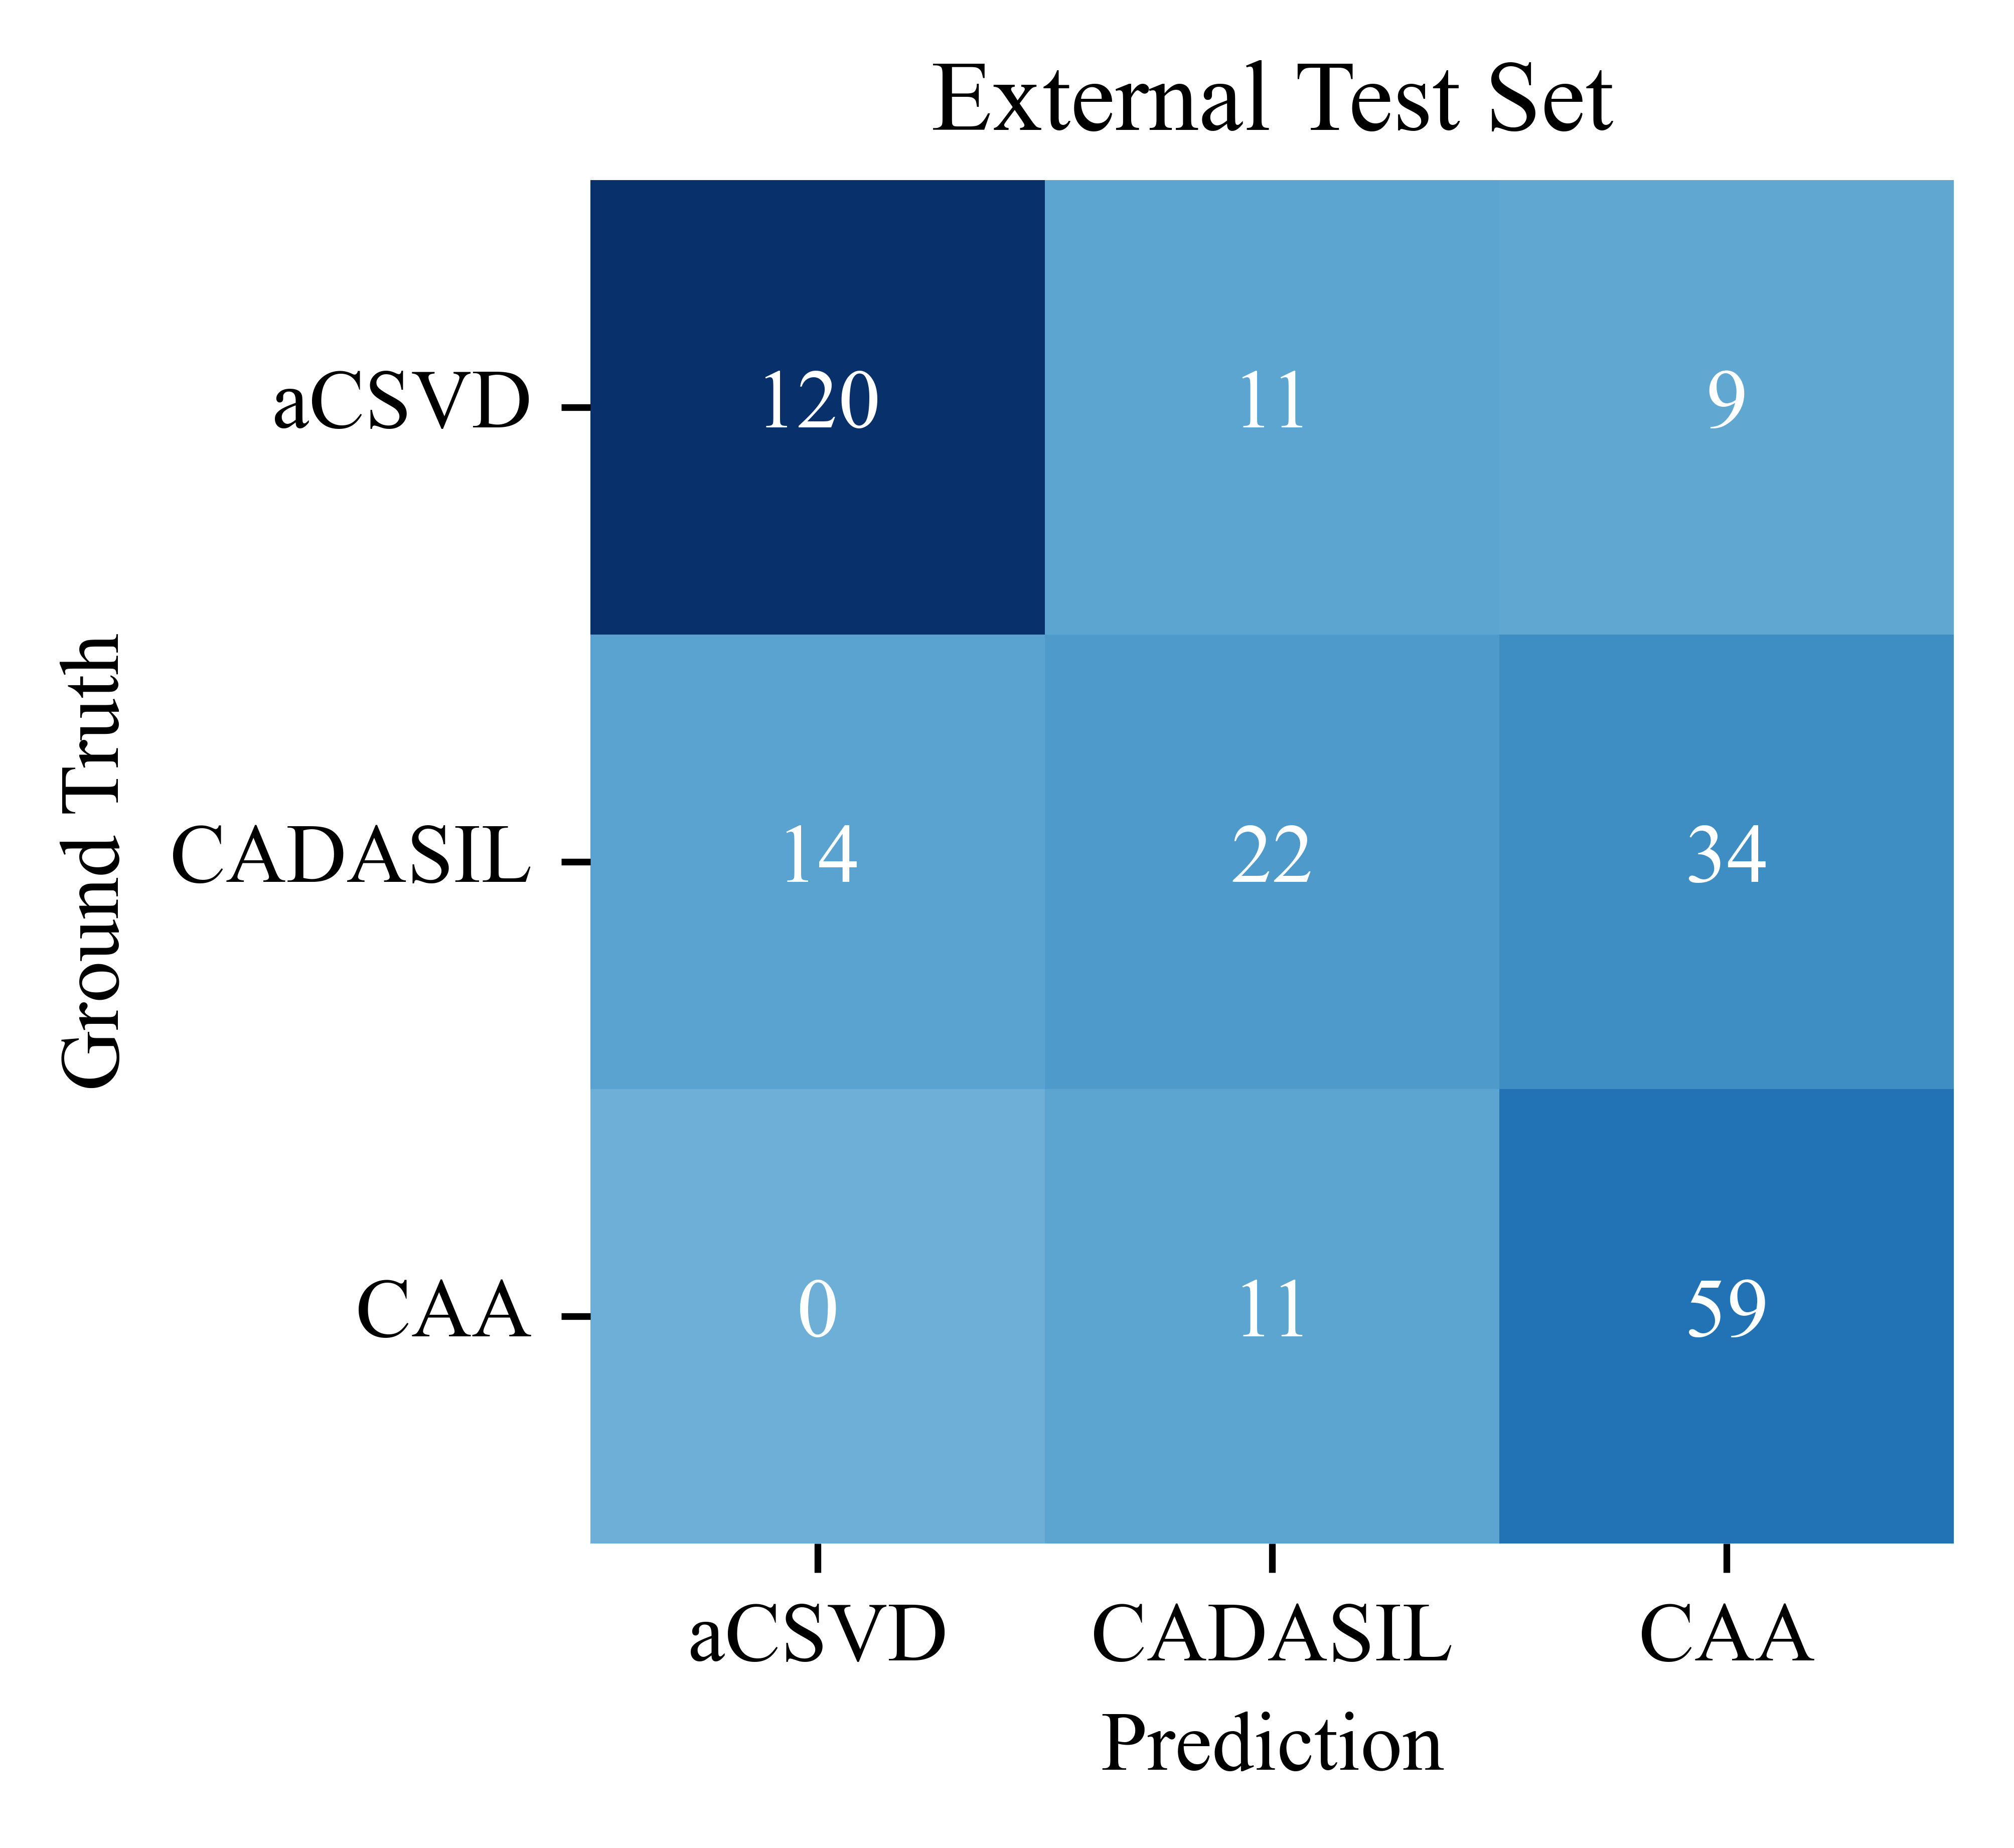

In [21]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_true = cls_labels.reshape(-1,)
y_prob = cls_probs.reshape(-1,3)
y_pred = np.argmax(y_prob,1)

cm = confusion_matrix(y_true,y_pred).astype(int)
fig = plt.figure(dpi=params['dpi'],figsize=(3,3))
ax = sns.heatmap(cm,annot=True,fmt='d',center=True,cmap='Blues',cbar=False)
ax.set_aspect('equal','box')
ax.set_xticks(ticks=[0.5,1.5,2.5],labels=['aCSVD','CADASIL','CAA'],rotation='horizontal')
ax.set_yticks(ticks=[0.5,1.5,2.5],labels=['aCSVD','CADASIL','CAA'],rotation='horizontal')
ax.set_xlabel('Prediction')
ax.set_ylabel('Ground Truth')
ax.set_title('External Test Set')
plt.savefig(params['filepath_save_KFold_ExtTestSet_CM'], dpi=params['dpi'], bbox_inches='tight')
plt.show()

### 保存各类指标到表格文件

将和集成模型一起保存

# 集成模型

## 集成模型在外部数据集的指标

### 外部测试集上的AUC及其95%CI

In [22]:
y_true = cls_labels[:,k]
y_prob = cls_probs.mean(axis=1)# numpy array
AUC_CI_score_df = AUC_CI_score(y_true=y_true, y_prob=y_prob, ci=95)
AUC_CI_score_df.rename(index=dict( (cls_index,cls_name) for cls_name, cls_index in list(params['clses_name'].items())[:3] ), inplace=True)
AI_ExtTestSet_AUC_df.loc[:,'ensemble_AUC'] = AUC_CI_score_df.values# 整理到表格中 

display(AI_ExtTestSet_AUC_df.T)  

aCSVD                      CADASIL  \
fold0_AUC         0.969, 95%CI: 0.960 ~ 0.978  0.745, 95%CI: 0.708 ~ 0.782   
fold1_AUC         0.959, 95%CI: 0.949 ~ 0.969  0.755, 95%CI: 0.715 ~ 0.795   
fold2_AUC         0.960, 95%CI: 0.950 ~ 0.970  0.755, 95%CI: 0.716 ~ 0.793   
fold3_AUC         0.959, 95%CI: 0.948 ~ 0.970  0.781, 95%CI: 0.743 ~ 0.818   
fold4_AUC         0.964, 95%CI: 0.954 ~ 0.974  0.850, 95%CI: 0.830 ~ 0.869   
fold5_AUC         0.964, 95%CI: 0.952 ~ 0.975  0.843, 95%CI: 0.819 ~ 0.867   
fold6_AUC         0.968, 95%CI: 0.958 ~ 0.978  0.793, 95%CI: 0.752 ~ 0.834   
fold7_AUC         0.964, 95%CI: 0.954 ~ 0.973  0.802, 95%CI: 0.762 ~ 0.842   
fold8_AUC         0.964, 95%CI: 0.952 ~ 0.975  0.829, 95%CI: 0.808 ~ 0.850   
fold9_AUC         0.960, 95%CI: 0.948 ~ 0.971  0.802, 95%CI: 0.768 ~ 0.836   
10 folds average                          NaN                          NaN   
ensemble_AUC      0.958, 95%CI: 0.948 ~ 0.969  0.768, 95%CI: 0.731 ~ 0.805   

                                          CAA                        micro  \
fold0_AUC         0.939, 95%CI: 0.926 ~ 0.952  0.849, 95%CI: 0.834 ~ 0.864   
fold1_AUC         0.946, 95%CI: 0.933 ~ 0.958  0.870, 95%CI: 0.854 ~ 0.886   
fold2_AUC         0.945, 95%CI: 0.932 ~ 0.958  0.860, 95%CI: 0.842 ~ 0.878   
fold3_AUC         0.939, 95%CI: 0.925 ~ 0.952  0.899, 95%CI: 0.885 ~ 0.913   
fold4_AUC         0.945, 95%CI: 0.934 ~ 0.955  0.909, 95%CI: 0.896 ~ 0.922   
fold5_AUC         0.939, 95%CI: 0.925 ~ 0.954  0.886, 95%CI: 0.872 ~ 0.900   
fold6_AUC         0.945, 95%CI: 0.932 ~ 0.958  0.870, 95%CI: 0.854 ~ 0.887   
fold7_AUC         0.946, 95%CI: 0.932 ~ 0.960  0.847, 95%CI: 0.828 ~ 0.865   
fold8_AUC         0.938, 95%CI: 0.925 ~ 0.951  0.916, 95%CI: 0.906 ~ 0.925   
fold9_AUC         0.945, 95%CI: 0.934 ~ 0.956  0.897, 95%CI: 0.882 ~ 0.913   
10 folds average                          NaN  0.877, 95%CI: 0.861 ~ 0.894   
ensemble_AUC      0.946, 95%CI: 0.932 ~ 0.959  0.887, 95%CI: 0.870 ~ 0.904   

                                        macro                     weighted  
fold0_AUC         0.884, 95%CI: 0.868 ~ 0.901  0.906, 95%CI: 0.892 ~ 0.919  
fold1_AUC         0.887, 95%CI: 0.869 ~ 0.904  0.905, 95%CI: 0.891 ~ 0.919  
fold2_AUC         0.887, 95%CI: 0.869 ~ 0.904  0.905, 95%CI: 0.891 ~ 0.919  
fold3_AUC         0.893, 95%CI: 0.876 ~ 0.910  0.909, 95%CI: 0.895 ~ 0.923  
fold4_AUC         0.919, 95%CI: 0.909 ~ 0.930  0.931, 95%CI: 0.921 ~ 0.940  
fold5_AUC         0.915, 95%CI: 0.902 ~ 0.929  0.927, 95%CI: 0.915 ~ 0.940  
fold6_AUC         0.902, 95%CI: 0.884 ~ 0.920  0.919, 95%CI: 0.904 ~ 0.933  
fold7_AUC         0.904, 95%CI: 0.886 ~ 0.922  0.919, 95%CI: 0.904 ~ 0.933  
fold8_AUC         0.910, 95%CI: 0.898 ~ 0.922  0.923, 95%CI: 0.912 ~ 0.935  
fold9_AUC         0.902, 95%CI: 0.886 ~ 0.918  0.916, 95%CI: 0.903 ~ 0.930  
10 folds average  0.881, 95%CI: 0.864 ~ 0.899  0.899, 95%CI: 0.885 ~ 0.914  
ensemble_AUC      0.891, 95%CI: 0.873 ~ 0.908  0.908, 95%CI: 0.893 ~ 0.922

### 外部测试集的ROC曲线（包括医生）

{0: 0.9592, 1: 0.7687, 2: 0.9456, 'micro': 0.8878, 'macro': 0.9138, 'weighted': 0.9273}
秦冰 S1
魏磊 S2
卢婷婷 S3
黄雪泓 J1
刘旭 J2


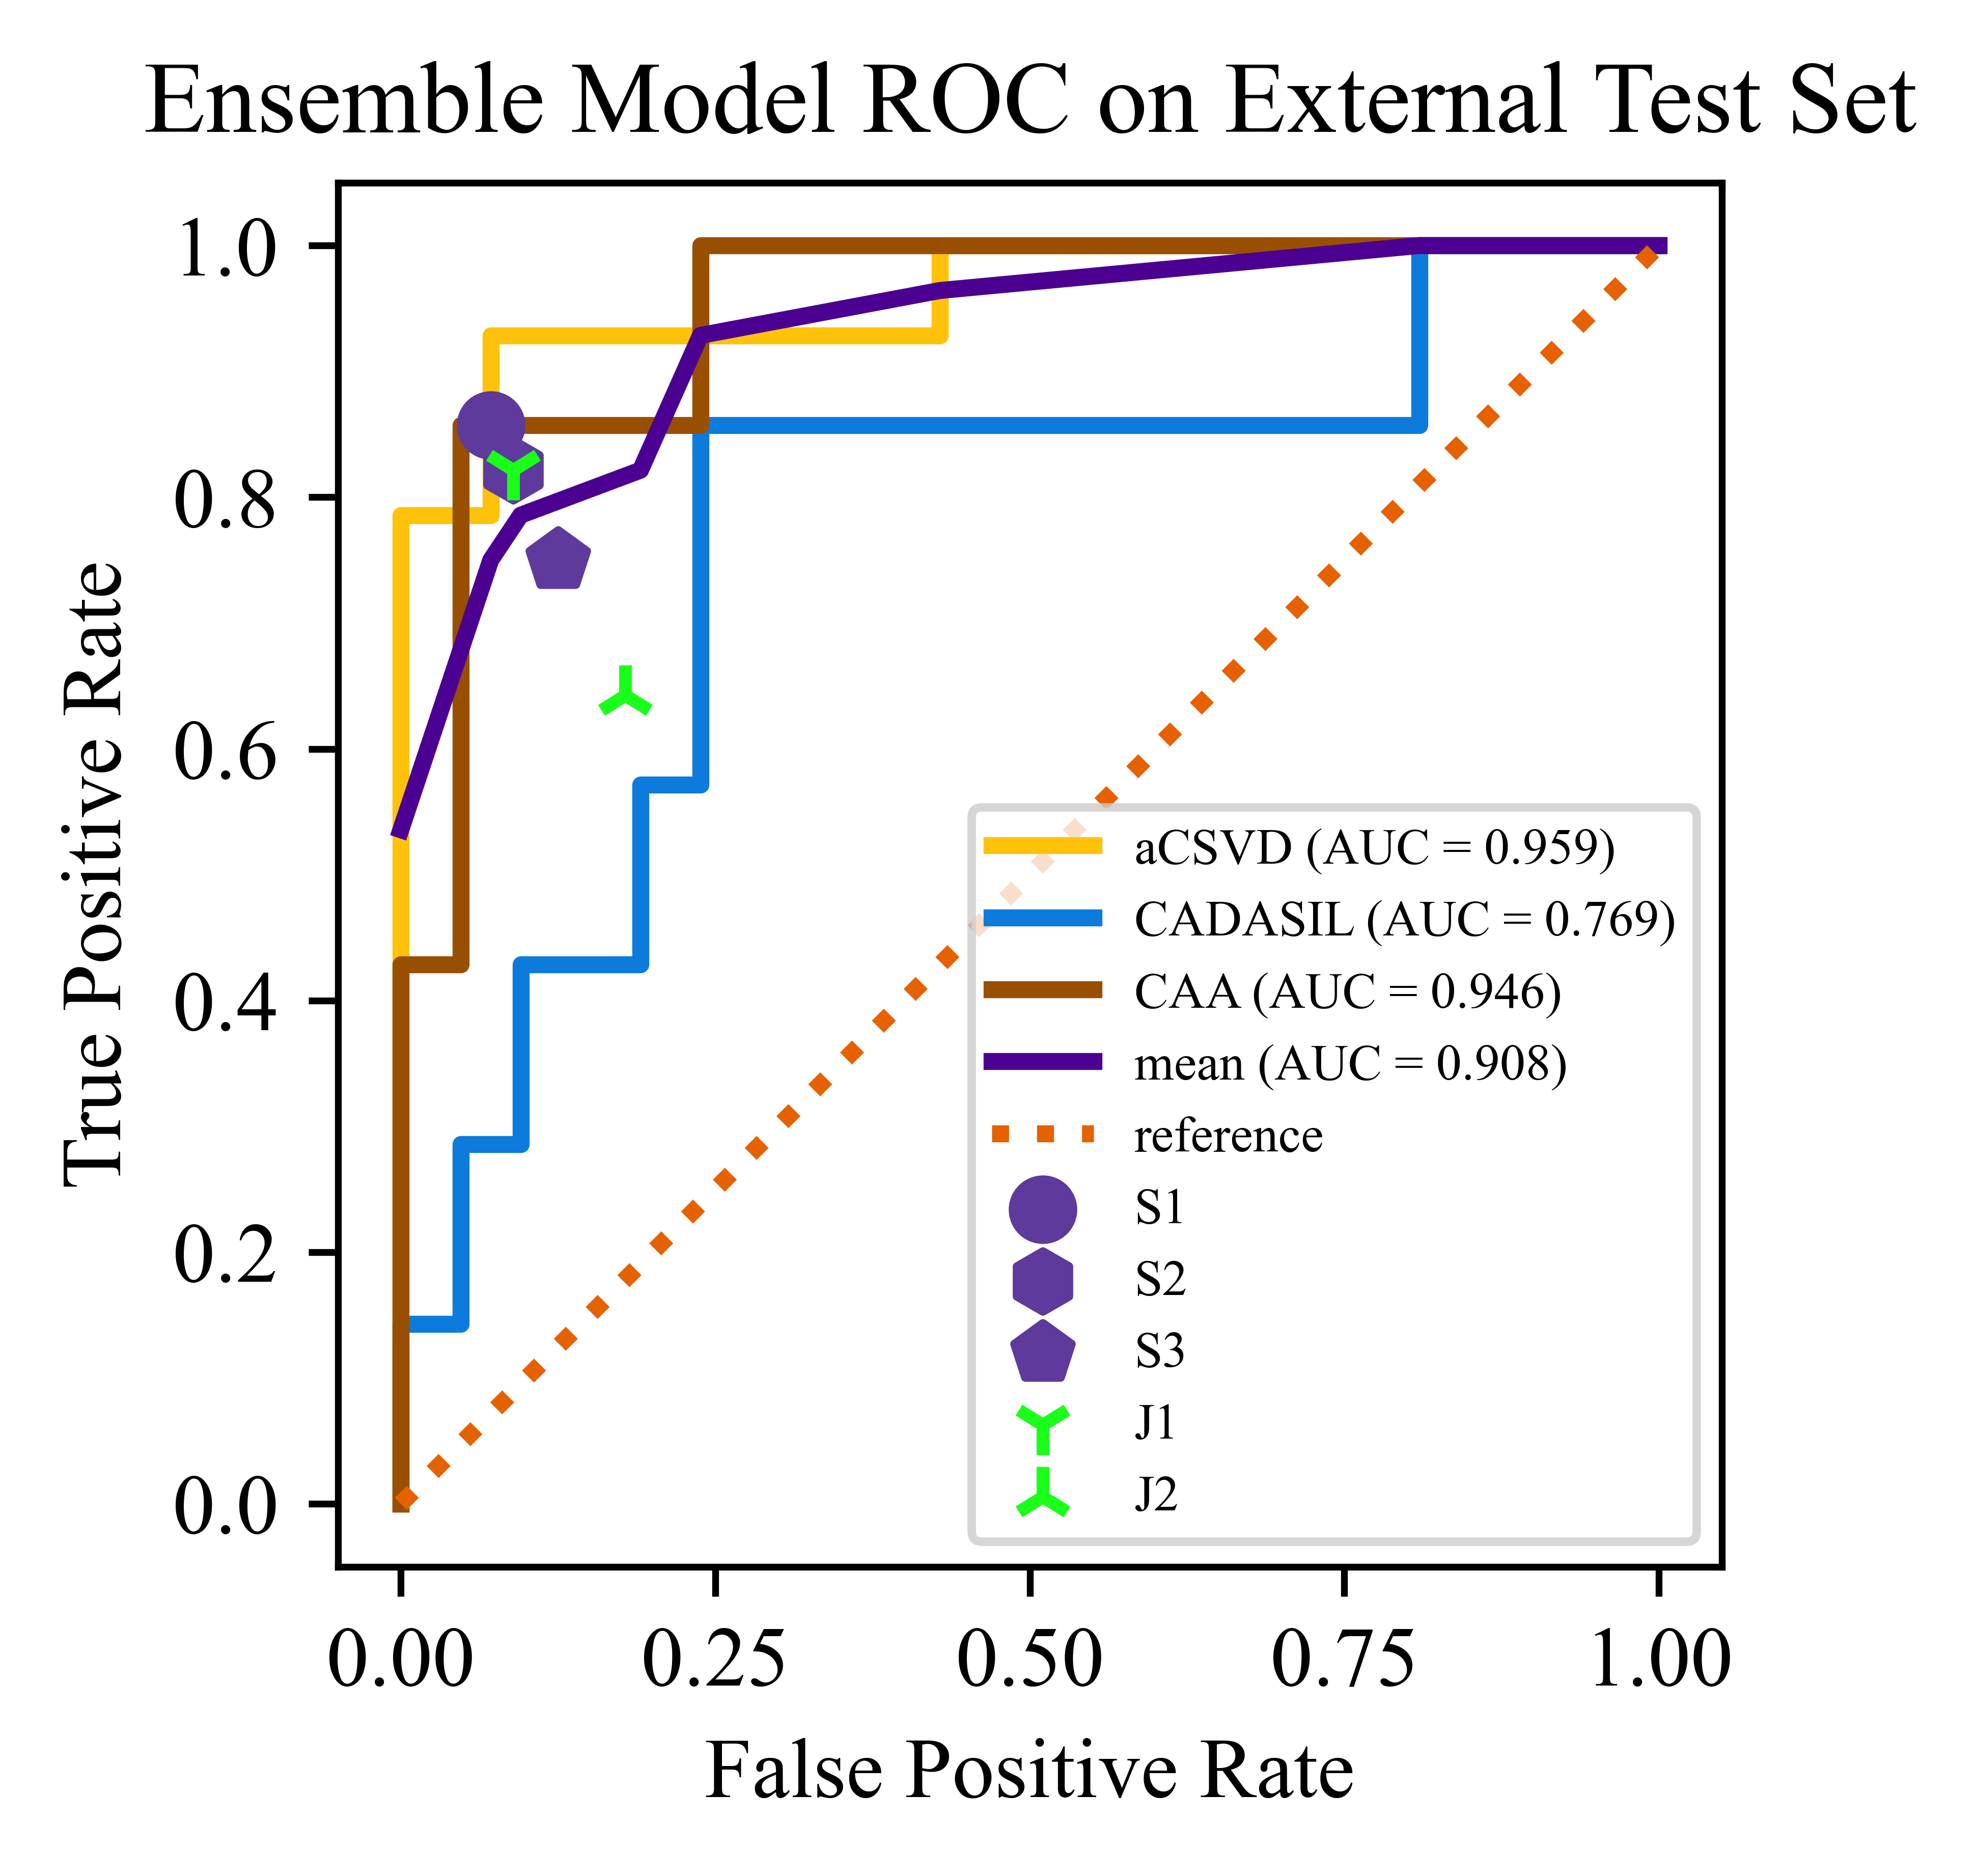

In [23]:
y_true = enc.fit_transform(cls_labels[:,1].reshape(-1,1))
y_true = y_true.toarray()
fpr, tpr, roc_auc = get_roc(y_true=y_true, y_score=cls_probs.mean(axis=1), n_classes=3)
print(roc_auc)

########### 画图：###########
import matplotlib.pyplot as plt
# 新建一块画布
fig,ax = plt.subplots(1,1,dpi=params['dpi'],figsize=(3,3))
# 画测试集的roc曲线
tmp_dict = params['clses_name']
tmp_dict.update({'mean':'weighted'})
ic = 0# 记录颜色序号
############################################################################################################
# 由于boostrap方法统计95%CI，存在一定随机性，倒是每次计算出来的数值最后一1~2位小数不固定，所以在此手动定义数值大小，用于绘图
AUC_SCORE = {"aCSVD":0.959, "CADASIL":0.769, "CAA":0.946, "mean":0.908}
############################################################################################################
for label_name, key in tmp_dict.items():
    if key in ['micro','macro','weighted']:
        auc_score = float(AI_ExtTestSet_AUC_df.loc[key,'ensemble_AUC'].split(',')[0])
        plt.plot(fpr[key], tpr[key],
#                  linestyle='--',
                 lw=2, 
                 label='{} (AUC = {:.3f})'.format(label_name,auc_score),
                 color=params['color_list'][ic],
                )
        ic += 1
    else:
        plt.plot(fpr[key], tpr[key],
                 lw=2, 
                 label='{} (AUC = {:.3f})'.format(label_name, roc_auc[key]),
                 color=params['color_list'][ic],
                )
        ic += 1
    
    
# 画参考线
plt.plot([0, 1], [0, 1], lw=2, linestyle=':',label='reference', color=params['color_list'][ic])
ic += 1
plt.xlabel('False Positive Rate')# x坐标轴名字
plt.ylabel('True Positive Rate')# y坐标轴名字
plt.title('Ensemble Model ROC on External Test Set')# 标题
# plt.legend(fonsize=10, loc="lower right")# 图例

# 画医生micro点
Dr_names = params['Dr_names']#['秦冰','魏磊','卢婷婷','黄雪泓','陆正齐','刘旭']
# ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
# markers = ( 'o', 'p', 'h', '>', '<', '^' )
markers = ( 'o', 'h', 'p', '1', '2' )
colors = (
    params['color_list'][ic],
    params['color_list'][ic],
    params['color_list'][ic],
    params['color_list'][ic+1],
    params['color_list'][ic+1],
    params['color_list'][ic+1],
)
labels = ('S1','S2','S3','J1','J2','J3')
for Dr_name, marker, color, label in zip(Dr_names,markers,colors,labels):
    print(Dr_name,label)
    plt.scatter( 
        x=Dr_ROC[Dr_name][0]['micro'][1], y=Dr_ROC[Dr_name][1]['micro'][1], 
        alpha=1.0, s=50, marker=marker, color=color, label=label, zorder=2)
plt.legend(fontsize=6, loc="lower right")# 图例
ax.set_xlim([-0.05,1.05])
ax.set_ylim([-0.05,1.05])
ax.set_aspect('equal','box')
plt.savefig(fname=params['filepath_save_EnsAI_ExtTestSet_ROC'],dpi=params['dpi'],bbox_inches='tight')
plt.show() 

### 外部测试集的classification_report及其95%CI

In [24]:
# 统计集成模型的classification report(包含95%CI)
import itertools as it
from sklearn.metrics import classification_report
y_true = cls_labels[:,0]    
ensAI_y_prob = cls_probs.mean(axis=1)

#####################################
# 不会影响AUC
if params['mix']:
    ensAI_y_prob[:,1] += 0.1
else:
    ensAI_y_prob[:,1] += 0.2
ensAI_y_pred = np.argmax(ensAI_y_prob,1)
#####################################

# 统计指标: precision/recall/f1score_accuracy/micro/macro    
y_true = y_true.astype(int) # numpy array
y_pred = ensAI_y_pred # numpy array
Ens_report_CI_df = classification_CI_report(y_true=y_true, y_pred=y_pred, ci=95)
display(Ens_report_CI_df)

/opt/conda/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2098: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/opt/conda/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2099: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


ACSVD                      CADASIL  \
precision      1.000, 95%CI: nan ~ nan  0.603, 95%CI: 0.536 ~ 0.669   
recall     0.782, 95%CI: 0.724 ~ 0.840  0.863, 95%CI: 0.780 ~ 0.946   
f1-score   0.877, 95%CI: 0.841 ~ 0.914  0.709, 95%CI: 0.647 ~ 0.771   

                                   CAA                     accuracy  \
precision  0.864, 95%CI: 0.792 ~ 0.937  0.823, 95%CI: 0.780 ~ 0.866   
recall     0.864, 95%CI: 0.784 ~ 0.944  0.823, 95%CI: 0.780 ~ 0.866   
f1-score   0.864, 95%CI: 0.803 ~ 0.924  0.823, 95%CI: 0.780 ~ 0.866   

                             macro avg                 weighted avg  
precision  0.822, 95%CI: 0.783 ~ 0.862  0.867, 95%CI: 0.837 ~ 0.896  
recall     0.836, 95%CI: 0.791 ~ 0.882  0.823, 95%CI: 0.780 ~ 0.866  
f1-score   0.817, 95%CI: 0.772 ~ 0.861  0.832, 95%CI: 0.793 ~ 0.871

### 外部测试集的混淆矩阵

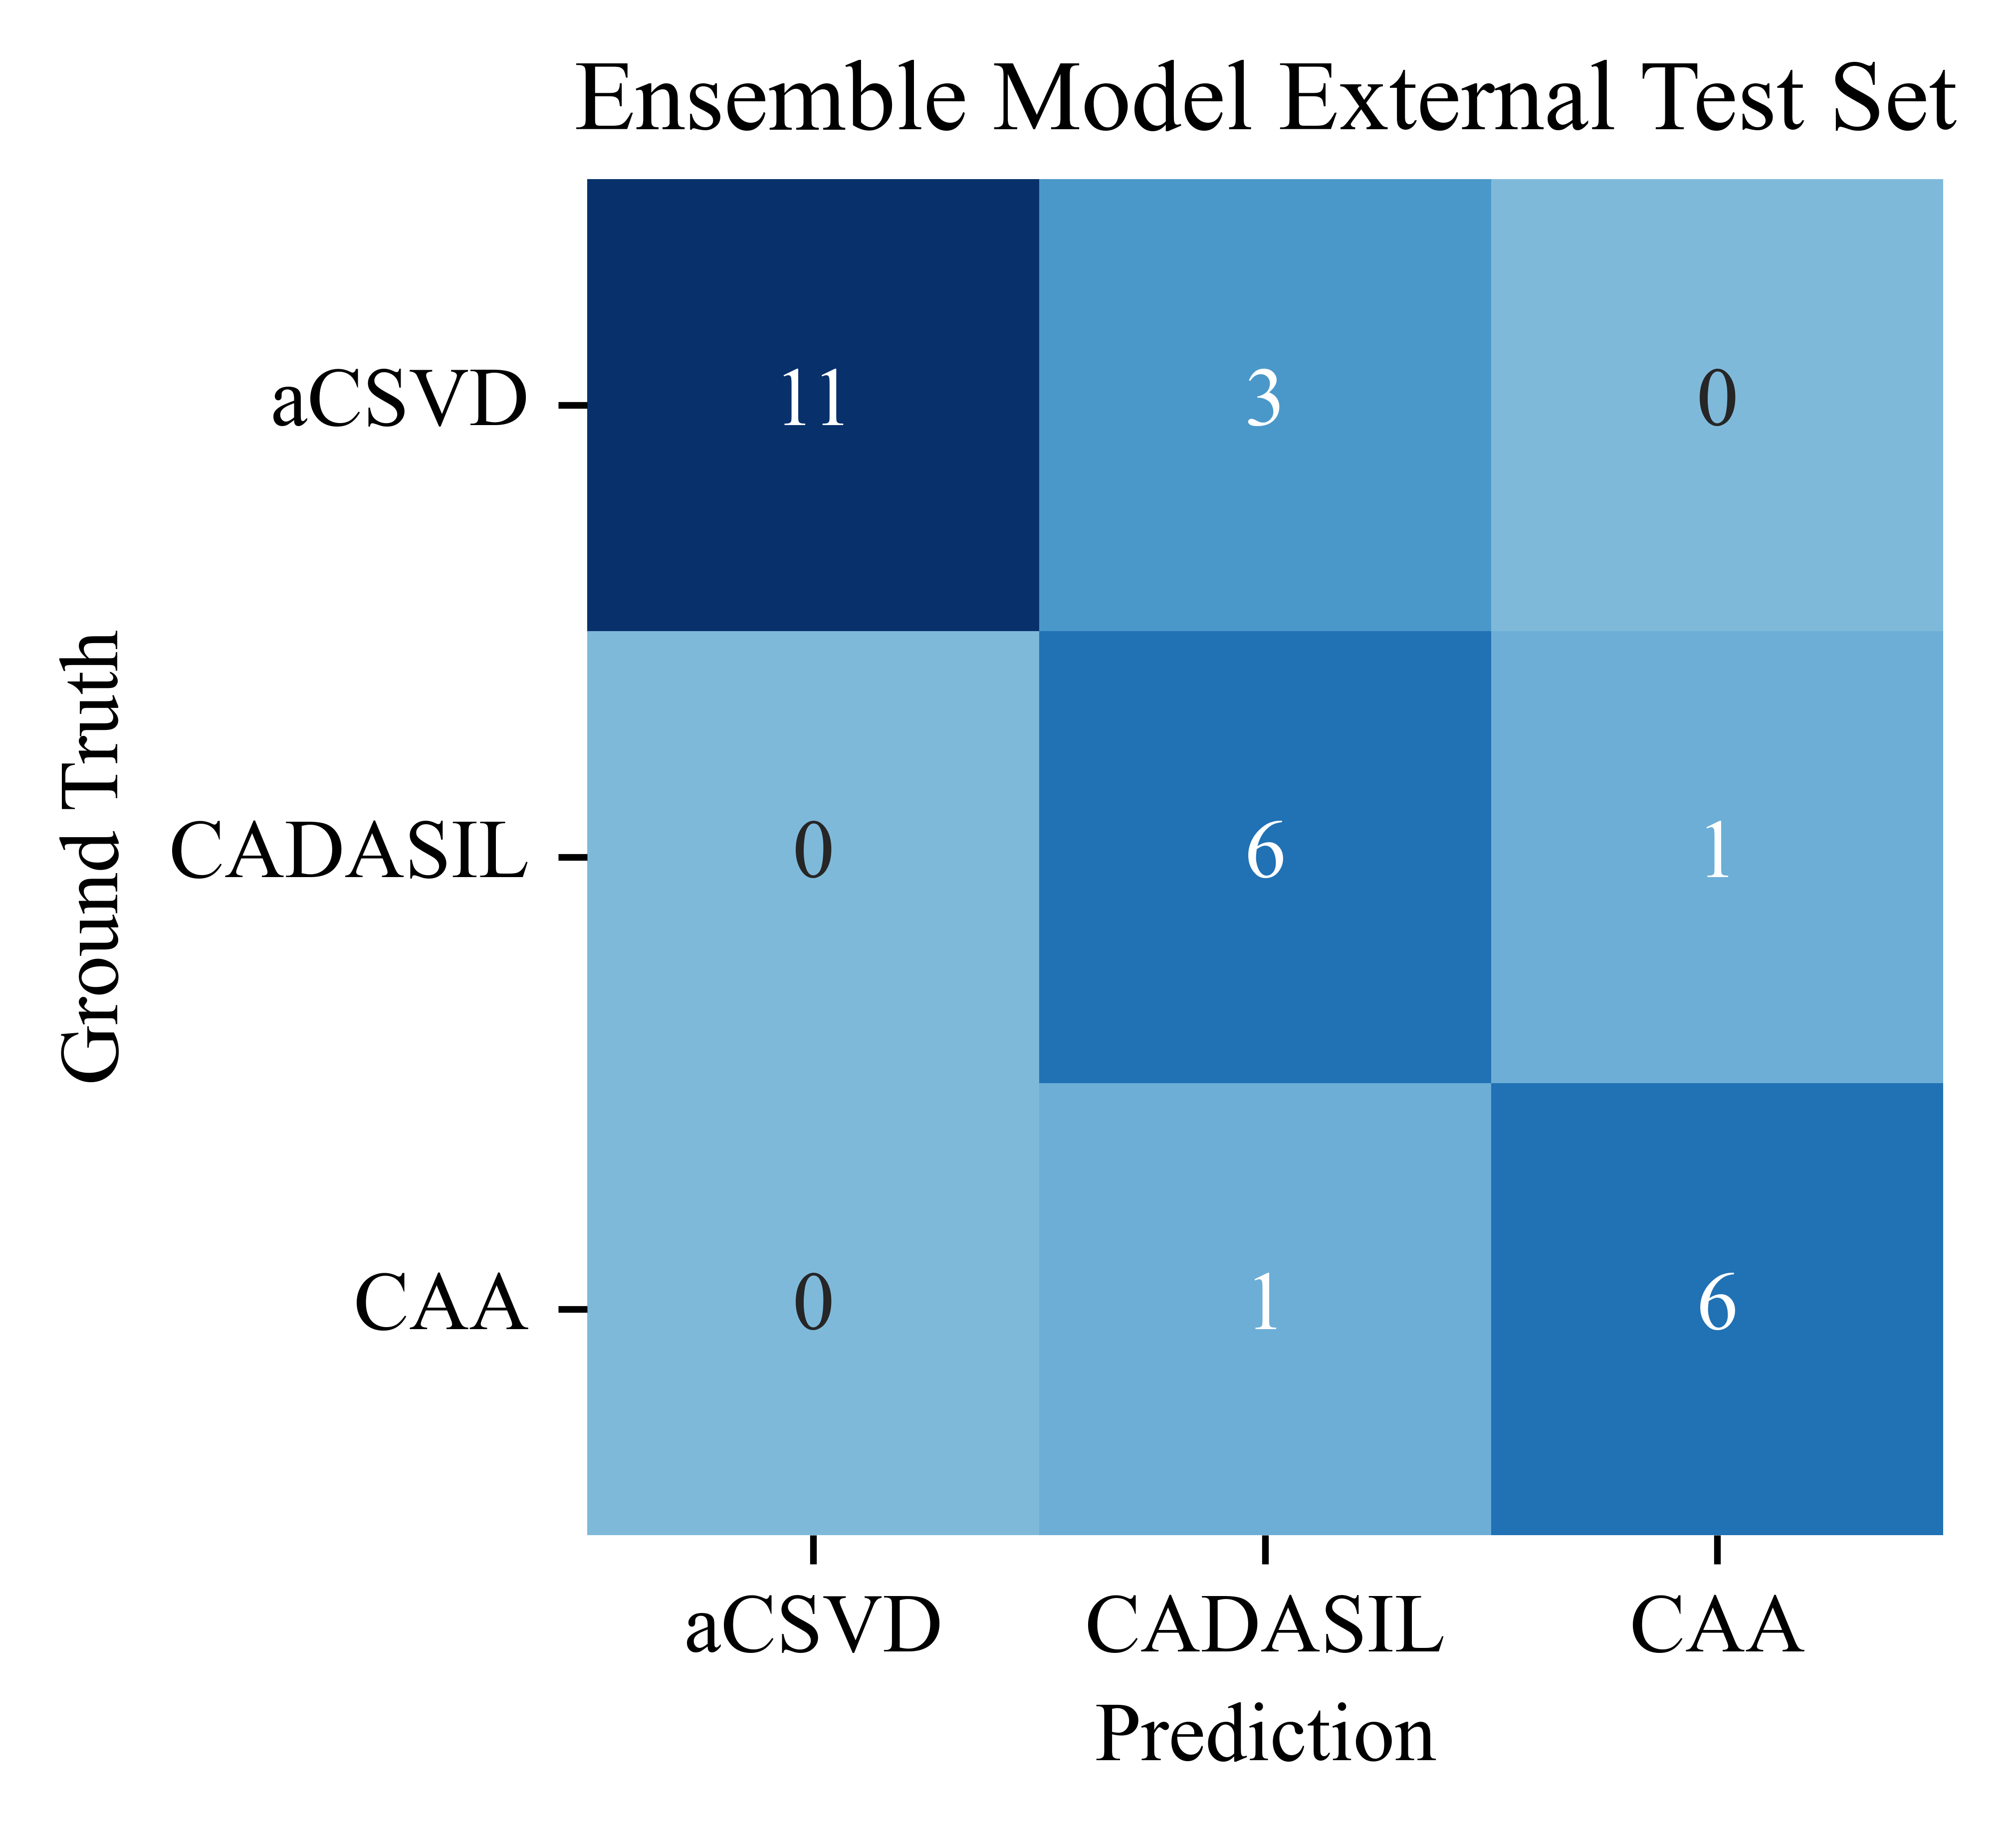

In [25]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(cls_labels[:,1],ensAI_y_pred).astype(int)
fig = plt.figure(dpi=params['dpi'],figsize=(3,3))
ax = sns.heatmap(cm,annot=True,fmt='d',center=True,cmap='Blues',cbar=False)
ax.set_aspect('equal','box')
ax.set_xticks(ticks=[0.5,1.5,2.5],labels=['aCSVD','CADASIL','CAA'],rotation='horizontal')
ax.set_yticks(ticks=[0.5,1.5,2.5],labels=['aCSVD','CADASIL','CAA'],rotation='horizontal')
ax.set_xlabel('Prediction')
ax.set_ylabel('Ground Truth')
ax.set_title('Ensemble Model External Test Set')
plt.savefig(params['filepath_save_EnsAI_ExtTestSet_CM'], dpi=params['dpi'], bbox_inches='tight')
plt.show()

### 保存各类指标到表格文件

In [26]:
with pd.ExcelWriter(params['filepath_save_KFold_and_Ens_ExtTestSet_Metrics']) as xlsx:
    AI_ExtTestSet_AUC_df.to_excel(xlsx, sheet_name="单模型的AUC")
    # 单个模型的report
    for sheet_name, report_dict in KFold_ExtTestSet_report_dict.items():
        report_dict.to_excel(xlsx, sheet_name=sheet_name)
    # 集成模型的report
    Ens_report_CI_df.to_excel(xlsx, sheet_name='集成模型')

# 人机对比
在外部测试集上，对比医生诊断结果和集成模型。<br>
方法： kappa一致性检验

In [27]:
from statsmodels.stats.inter_rater import cohens_kappa

# 准备医生数据
Cohen_dict = dict([])
for Dr_name in Dr_names:
    # 读取数据并预处理
    Dr_df = pd.read_excel(params['filepath_Human_prediction'],sheet_name=Dr_name)
    
    # 重新命名列
    Dr_df.rename( columns={'诊断':'y_pred', 'Ground truth':'y_true'}, inplace=True )
#     # 类别名称转为大写
#     Dr_df['y_pred'] = Dr_df['y_pred'].apply(lambda x: x.upper())
#     Dr_df['y_true'] = Dr_df['y_true'].apply(lambda x: x.upper())
    # 设置patient_ID作为index
    for idx in Dr_df.index:
        Dr_df.loc[idx, 'ID'] = '{}_{:0>3d}'.format( Dr_df.loc[idx, 'y_true'], Dr_df.loc[idx, '原先ID']  )
    Dr_df.set_index( keys=['ID'], inplace=True )
    # 删除不是本研究疾病类型的病例
    Dr_df = Dr_df[ Dr_df['y_pred'].apply(lambda x: x in params['clses_name'].keys()) ]
    # 类别名称转为数字代号
    Dr_df['y_pred'] = Dr_df['y_pred'].apply(lambda x: params['clses_name'][x])
    Dr_df['y_true'] = Dr_df['y_true'].apply(lambda x: params['clses_name'][x])
    
    # 丢掉不需要的列
    Dr_df.drop( columns=["编号","原先ID"], inplace=True )
    # 排序index
    Dr_df.sort_index(inplace=True)
    Cohen_dict[Dr_name] = Dr_df
    
# 准备集成模型数据
# 外部测试集病例ID
patient_IDs = [ '_'.join(patient_ID[0].split(os.sep)[-2:]).replace('_SWS.nii.gz','') for patient_ID in test_loader.dataset.patient_IDs]
# 标签
GT_label = [ test_loader.dataset.getlabel(i)['class'] for i in range(len(patient_IDs)) ]
# 集成模型预测值ensAI_y_pred
# 整理为dataframe
ensAI_df = pd.DataFrame( 
    index=patient_IDs,
    columns=['y_pred','y_true'], 
    data=np.array([ensAI_y_pred, np.array(GT_label)]).T )
# 排序index
ensAI_df = ensAI_df.loc[ list(Dr_df.index) ]
Cohen_dict['AI集成模型'] = ensAI_df


GT_df = pd.DataFrame( 
    index=patient_IDs,
    columns=['y_pred','y_true'], 
    data=np.array([np.array(GT_label), np.array(GT_label)]).T )
Cohen_dict['GroundTruth'] = GT_df

# 执行kappa一致性检验
kappa_df = pd.DataFrame(index=Cohen_dict.keys(), columns=Cohen_dict.keys())
for name0, name1 in it.product( Cohen_dict.keys(), Cohen_dict.keys() ):
    cm = confusion_matrix( Cohen_dict[name0].loc[:,'y_pred'], Cohen_dict[name1].loc[Cohen_dict[name0].index,'y_pred'] ).astype(int)
    kappa_df.loc[name0, name1] = cohens_kappa(cm)['kappa']
display(kappa_df)

with pd.ExcelWriter(params[ 'filepath_save_KappaConsistencyTest_ExtTestSet']) as xlsx:
    kappa_df.to_excel(xlsx, sheet_name="医生和集成模型在外部测试集的Kappa一致性检验系数")

秦冰        魏磊       卢婷婷       黄雪泓        刘旭    AI集成模型  \
秦冰                1.0  0.714286  0.601626  0.656442  0.434343  0.558185   
魏磊           0.714286       1.0  0.666667  0.943434  0.454191  0.559921   
卢婷婷          0.601626  0.666667       1.0  0.611881  0.326653   0.51068   
黄雪泓          0.656442  0.943434  0.611881       1.0  0.407692  0.557312   
刘旭           0.434343  0.454191  0.326653  0.407692       1.0  0.305344   
AI集成模型       0.558185  0.559921   0.51068  0.557312  0.305344       1.0   
GroundTruth  0.768116   0.71831  0.605634   0.71831   0.43662  0.726027   

            GroundTruth  
秦冰             0.768116  
魏磊              0.71831  
卢婷婷            0.605634  
黄雪泓             0.71831  
刘旭              0.43662  
AI集成模型         0.726027  
GroundTruth         1.0

# 绘制热图

In [28]:
test_dataset

In [37]:
if __name__ == "__main__":
    
    # from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
    from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
    from pytorch_grad_cam.utils.image import show_cam_on_image

    # Note: input_tensor can be a batch tensor with several images!
    # You can also use it within a with statement, to make sure it is freed,
    # In case you need to re-create it inside an outer loop:
    # with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
    #   ...
    
    if not os.path.exists( params['heatmap_dir'] ):
        os.makedirs( params['heatmap_dir'] )
    
    y_pred = []
    for sample_idx, sample in tqdm(enumerate(test_dataset)):
        # get a test sample
        sample = test_dataset[sample_idx]
        image, label = sample[0], sample[1]
        label = label['class']
        if params['mix']:
            clin = sample[2]
            clin = torch.cat( [torch.tensor([v for v in clin.values()]).unsqueeze(0)],dim=0)
            clin = clin.float().to(device)
        
        image = image.to(device)# an input tensor image for your model..
        if params['mix']:
            input_tensor = ( image, clin ) # a tuple
        else:
            input_tensor = image# an input tensor image for your model..
            
        
        # 预测
        y_pred.append( model(input_tensor).detach().cpu().numpy() )
        
        ##########################################################################################
        # If target_category is None, the highest scoring category
        # will be used for every image in the batch.
        # target_category can also be an integer, or a list of different integers
        # for every image in the batch.
        target_category = None# [label]# * input_tensor.size(0)# None

        
        # gradcam目标层通常是最后一个卷积层
        target_layers = [ model.resnet_baseline.layer3, ]
        # model.resnet_baseline.layer3[5].conv3
        # Construct the CAM object once, and then re-use it on many images:
        cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True if device=='cuda' else False)# , uses_gradients=False

        # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
        grayscale_cam = cam(input_tensor=input_tensor, target_category=target_category)
        
        visual_all = []
        n_slice = image.shape[0]
        for k in range( n_slice ):
            img = image[k][0,:,:].detach().cpu().numpy()/255.0
            visualization = show_cam_on_image(img, img*grayscale_cam[k], use_rgb=True)# 黑色背景不要叠热图
            visual_all.append( visualization.transpose((2,0,1)) )
        visual_all_tensor = torch.tensor( np.array(visual_all) )
        
        # 显示一个batch的图片 
        # 热图
#         grayscale_cam[:,np.newaxis,...]
        # 原图
        image_batch = torchvision.utils.make_grid(image[:,[0,],:,:].cpu(),padding = 5)
        fig,axs = plt.subplots(1,1,dpi=params['gray_dpi'],figsize=(3,3))
        plt.imshow(np.transpose(image_batch.numpy()/255.0, (1, 2, 0)),cmap='gray')
        plt.axis('off')
        fp_splits = test_dataset._filepath_list[sample_idx][0].split(os.path.sep)
        name_dataset, cls, sample_id, file = fp_splits[-4], fp_splits[-3], fp_splits[-2], fp_splits[-1]
#         plt.title( '{}'.format(sample_id), fontsize=5 )
        fig.tight_layout()
        filepath = os.path.join( params['heatmap_dir'], '-'.join([name_dataset, cls, sample_id, file, 'image.tiff']) )
        plt.savefig(filepath, dpi=params['gray_dpi'], bbox_inches='tight')
        plt.close()
        
        # 热图叠加在原图上
        image_batch = torchvision.utils.make_grid(visual_all_tensor/255.0,padding = 5)
        fig,axs = plt.subplots(1,1,dpi=params['gray_dpi'],figsize=(3,3))
        plt.imshow(np.transpose(image_batch.numpy(),(1, 2, 0)),cmap='viridis')#,'hot','rainbow','gray'
        cb = plt.colorbar(label="Grad-CAM", orientation="horizontal", fraction=0.05, pad=0.01, aspect=30) # colorbar
        cb_font = { 'weight': 'normal', 'size': 5, }
        cb.set_label('Grad-CAM',fontdict=cb_font)
        cb.ax.tick_params(labelsize=5)
        
        
        plt.axis('off')
        fp_splits = test_dataset._filepath_list[sample_idx][0].split(os.path.sep)
        name_dataset, cls, sample_id, file = fp_splits[-4], fp_splits[-3], fp_splits[-2], fp_splits[-1]
#         plt.title( '{}'.format(sample_id), fontsize=5 )
        fig.tight_layout()
        filepath = os.path.join( params['heatmap_dir'], '-'.join([name_dataset, cls, sample_id, file, 'show_heatmap_on_image.tiff']) )
        plt.savefig(filepath, dpi=params['gray_dpi'], bbox_inches='tight')
#         plt.show()
        plt.close()
        ##########################################################################################

28it [01:12,  2.58s/it]
